# BDT optimised with Working Point parametrized on (Mu, Eta) and (Eta, pT) and (Eta, pT, Mu)

In [1]:
import numpy as np
import pandas as pd
import pickle

from matplotlib import pyplot as plt

import hist
import scipy
from scipy import optimize

In [2]:
datadir = "/home/chardong/y_identification/Venv/save_pkl/df_test_sample_hard_scattering/"
savedir = "/home/chardong/y_identification/Venv/save_plots/"

In [3]:
df = pd.read_pickle(datadir+"df_test_combined_sample_hard_scattering_skim30.pkl")
df.columns
#df.head()

Index(['y_pt', 'y_eta', 'y_phi', 'y_convRadius', 'y_convType', 'weight',
       'truth_label', 'evt_mu', 'y_IsLoose', 'y_IsTight', 'y_truth_pt',
       'y_truth_eta', 'background_score', 'signal_score'],
      dtype='object')

In [4]:
# y_eta
edges_eta = [0, 0.6, 0.8, 1.15, 1.37, 1.52, 1.81, 2.01, 2.37]

# y_pt
edges_pt_bkg = [20,  25,  30,  35,  40,  45, 50, 65, 490]
edges_pt_sig = edges_pt_bkg

# evt-mu
edges_mu =  [0., 16., 22., 24., 26., 28., 30., 32., 34., 36., 40., 44., 46., 48., 60]
#[5, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 34.0, 36.0, 40]

### Créer des axes de structure de bins

In [5]:
# Créer des axes de structure de bins
axis_eta     =  hist.axis.Variable(edges_eta,     name="eta",    label=r"$\eta$")
axis_mu      =  hist.axis.Variable(edges_mu,      name='evt_mu', label=r"$evt_\mu$ [GeV]")
axis_pt_sig  =  hist.axis.Variable(edges_pt_sig,  name='pt',     label=r"$p_T$ [GeV]")
axis_pt_bkg  =  hist.axis.Variable(edges_pt_bkg,  name='pt',     label=r"$p_T$ [GeV]")

In [6]:
# Preselection on photon passin Loose cut-based selection 
df = df.query('y_IsLoose == 1')
# Restict pT range to pT histogram edges also for mu plot to avoid artifacts
df = df.query('20. < y_pt < 500.')
# Adding column with absolute eta value, assuming symmetry
df['y_abs_eta'] = np.abs(df['y_eta'])

#df.head()

In [7]:
# Nouvelles colones pt_bin_.. dans le df assignant chaque valeur de y_abs_eta à un bin de l'histograme axis_... 
df = df.assign(pt_bin_sig=axis_pt_sig.index(df['y_pt']))
df = df.assign(pt_bin_bkg=axis_pt_bkg.index(df['y_pt']))

# Nouvelles colones eta_bin_.. dans le df assignant chaque valeur de y_abs_eta à un bin de l'histograme axis_... 
df = df.assign(eta_bin_sig=axis_eta.index(df['y_abs_eta']))
df = df.assign(eta_bin_bkg=axis_eta.index(df['y_abs_eta']))

# Assiging indices correspoding to bins to each event in dataset
df = df.assign(mu_bin_sig=axis_mu.index(df['evt_mu']))       #Mapper les valeur de evt_mu aux bins définis par axis_mu.
df = df.assign(mu_bin_bkg=axis_mu.index(df['evt_mu']))

In [8]:
df_sig = df.query('truth_label==1')
df_bkg = df.query('truth_label==0')

df_sig_tight = df_sig[(df_sig["y_IsTight"]==1)]  #bouléen
df_bkg_tight = df_bkg[(df_bkg["y_IsTight"]==1)]

### Efficiency function

In [9]:
def efficiency(num,den):
    eff = (num/den).values()
    efferr = np.sqrt(eff*(1.-eff)/den.values())
    return eff, efferr

# Compute Tight efficiencies as a function of $\eta$ and $\mu$ and of $\eta$ and $p_T$

### Histograms for mu, eta et pT

In [10]:
# Histograms and Axes pour `mu` et 'eta'
den_sig_EtapTmu = hist.Hist(axis_eta, axis_pt_sig, axis_mu).fill(df_sig["y_abs_eta"], df_sig["y_pt"], df_sig["evt_mu"])   #before cut-base
den_bkg_EtapTmu = hist.Hist(axis_eta, axis_pt_bkg, axis_mu).fill(df_bkg["y_abs_eta"], df_bkg["y_pt"], df_bkg["evt_mu"])

num_sig_tight_EtapTmu = hist.Hist(axis_eta, axis_pt_sig, axis_mu).fill(df_sig_tight["y_abs_eta"], 
                                                                       df_sig_tight["y_pt"], df_sig_tight["evt_mu"])   #after cut-base
num_bkg_tight_EtapTmu = hist.Hist(axis_eta, axis_pt_bkg, axis_mu).fill(df_bkg_tight["y_abs_eta"], 
                                                                       df_bkg_tight["y_pt"], df_bkg_tight["evt_mu"])

In [11]:
eff_sig_tight_EtapTmu, efferr_sig_tight_EtapTmu = efficiency(num_sig_tight_EtapTmu, den_sig_EtapTmu)  # binomial uncertainty on efficiency
eff_bkg_tight_EtapTmu, efferr_bkg_tight_EtapTmu = efficiency(num_bkg_tight_EtapTmu, den_bkg_EtapTmu)  # binomial uncertainty on efficiency

### Histograms for mu et eta

In [12]:
# Histograms and Axes pour `mu` et 'eta'
den_sig_EtaMu = hist.Hist(axis_eta, axis_mu).fill(df_sig["y_abs_eta"], df_sig["evt_mu"])   #before cut-base Tight
den_bkg_EtaMu = hist.Hist(axis_eta, axis_mu).fill(df_bkg["y_abs_eta"], df_bkg["evt_mu"])

num_sig_tight_EtaMu = hist.Hist(axis_eta, axis_mu).fill(df_sig_tight["y_abs_eta"], df_sig_tight["evt_mu"])   #after cut-base Tight
num_bkg_tight_EtaMu = hist.Hist(axis_eta, axis_mu).fill(df_bkg_tight["y_abs_eta"], df_bkg_tight["evt_mu"])

In [13]:
eff_sig_tight_EtaMu, efferr_sig_tight_EtaMu = efficiency(num_sig_tight_EtaMu, den_sig_EtaMu)  # binomial uncertainty on efficiency
eff_bkg_tight_EtaMu, efferr_bkg_tight_EtaMu = efficiency(num_bkg_tight_EtaMu, den_bkg_EtaMu)  # binomial uncertainty on efficiency

### Histograms for pt et eta

In [14]:
# Histograms and Axes pour 'pt' et 'eta'
den_sig_EtapT = hist.Hist(axis_eta, axis_pt_sig).fill(df_sig["y_abs_eta"], df_sig["y_pt"])   #before CBT
den_bkg_EtapT = hist.Hist(axis_eta, axis_pt_bkg).fill(df_bkg["y_abs_eta"], df_bkg["y_pt"])

num_sig_tight_EtapT = hist.Hist(axis_eta, axis_pt_sig).fill(df_sig_tight["y_abs_eta"], df_sig_tight["y_pt"])   #after CBT
num_bkg_tight_EtapT = hist.Hist(axis_eta, axis_pt_bkg).fill(df_bkg_tight["y_abs_eta"], df_bkg_tight["y_pt"])

In [15]:
eff_sig_tight_EtapT, efferr_sig_tight_EtapT = efficiency(num_sig_tight_EtapT, den_sig_EtapT)  # binomial uncertainty on efficiency
eff_bkg_tight_EtapT, efferr_bkg_tight_EtapT = efficiency(num_bkg_tight_EtapT, den_bkg_EtapT)  # binomial uncertainty on efficiency

### Histograms for eta

In [16]:
# Histograms and Axes pour 'eta'
den_sig_eta = hist.Hist(axis_eta).fill(df_sig["y_abs_eta"])   #before cut-base
den_bkg_eta = hist.Hist(axis_eta).fill(df_bkg["y_abs_eta"])

num_sig_tight_eta = hist.Hist(axis_eta).fill(df_sig_tight["y_abs_eta"])   #after cut-base
num_bkg_tight_eta = hist.Hist(axis_eta).fill(df_bkg_tight["y_abs_eta"])

In [17]:
eff_sig_tight_eta, efferr_sig_tight_eta = efficiency(num_sig_tight_eta, den_sig_eta)  # binomial uncertainty on efficiency
eff_bkg_tight_eta, efferr_bkg_tight_eta = efficiency(num_bkg_tight_eta, den_bkg_eta)  # binomial uncertainty on efficiency

### Histograms for Mu

In [18]:
# Histograms and Axes pour 'eta'
den_sig_mu = hist.Hist(axis_mu).fill(df_sig["evt_mu"])   #before cut-base
den_bkg_mu = hist.Hist(axis_mu).fill(df_bkg["evt_mu"])

num_sig_tight_mu = hist.Hist(axis_mu).fill(df_sig_tight["evt_mu"])   #after cut-base
num_bkg_tight_mu = hist.Hist(axis_mu).fill(df_bkg_tight["evt_mu"])

In [19]:
eff_sig_tight_mu, efferr_sig_tight_mu = efficiency(num_sig_tight_mu, den_sig_mu)  # binomial uncertainty on efficiency
eff_bkg_tight_mu, efferr_bkg_tight_mu = efficiency(num_bkg_tight_mu, den_bkg_mu)  # binomial uncertainty on efficiency

In [20]:
# Convertir histogramme en listes ou arrays pour tracer avec matplotlib
mu     =   axis_mu.centers
pt_sig =   axis_pt_sig.centers
pt_bkg =   axis_pt_bkg.centers
eta    =   axis_eta.centers

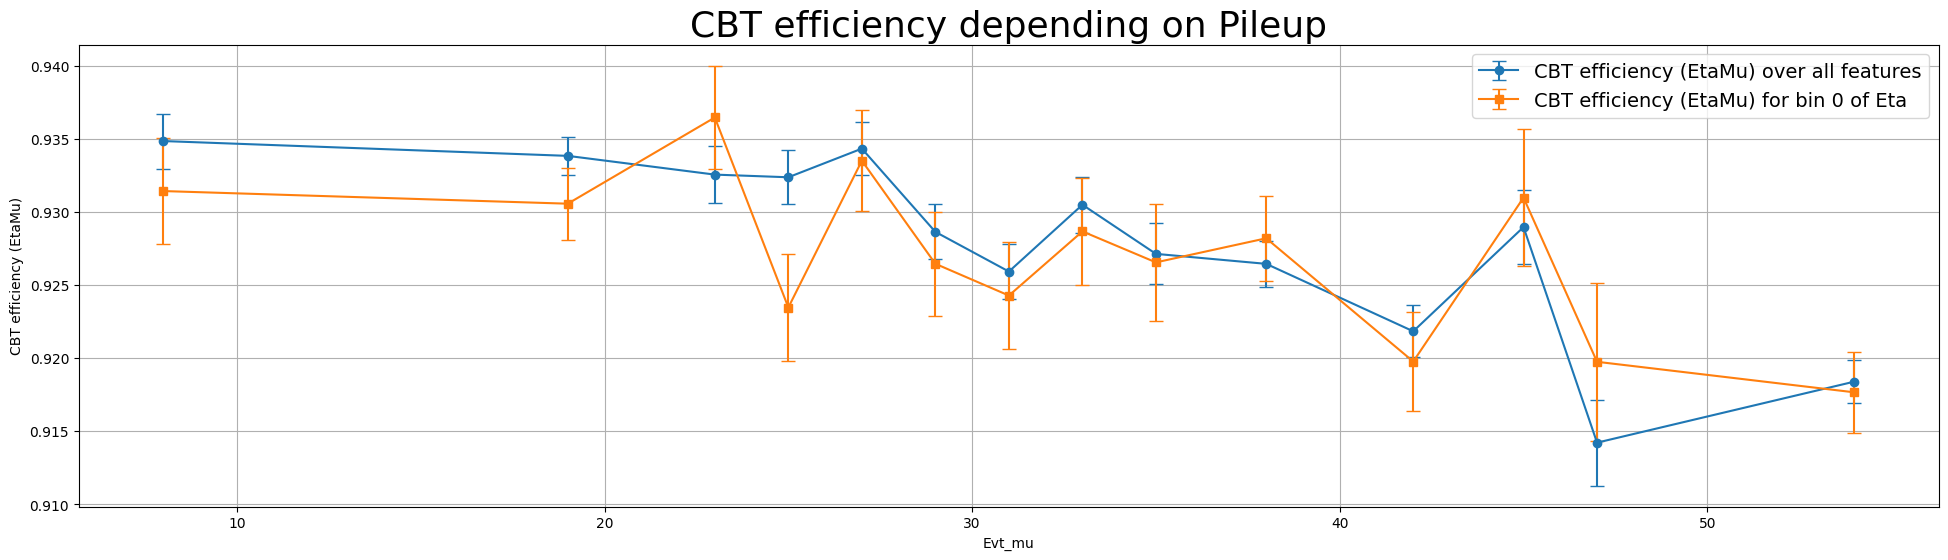

In [21]:
plt.figure(figsize=(24, 6))

plt.errorbar(mu, eff_sig_tight_mu, yerr=efferr_sig_tight_mu, fmt='o-', capsize=5, label='CBT efficiency (EtaMu) over all features')
plt.errorbar(mu, eff_sig_tight_EtaMu[0,:], yerr=efferr_sig_tight_EtaMu[0,:], fmt='s-', capsize=5, label='CBT efficiency (EtaMu) for bin 0 of Eta')

plt.xlabel('Evt_mu')
plt.ylabel('CBT efficiency (EtaMu)')
plt.title('CBT efficiency depending on Pileup', fontsize=26)
plt.grid(True)
plt.legend(loc='best', fontsize=14)

plt.show()

## CBT efficiency depending on Pileup over all bins of Eta from 2D Hist (Eta;Mu)

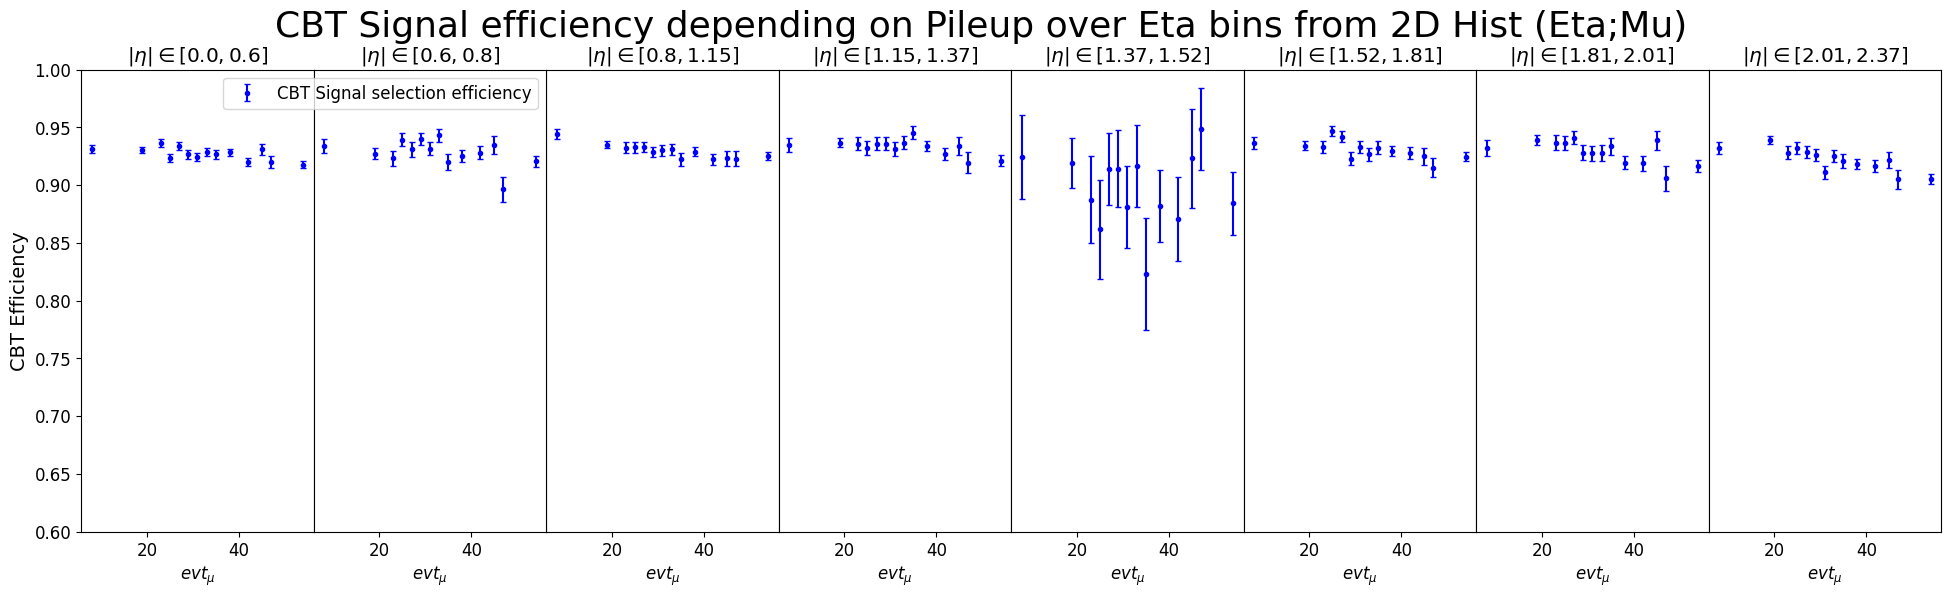

In [22]:
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(24,6))
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(mu, eff_sig_tight_EtaMu[i], yerr=efferr_sig_tight_EtaMu[i],
        fmt=".", capsize=2, label='CBT Signal selection efficiency', color = 'blue')  
    #ax[i].set_xscale('log')
    if (i!=0):
        ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    ax[i].set_xlabel('$evt_{\mu}$')
    ax[i].set_ylim([0.6, 1.0])
    
        
ax[0].set_ylabel("CBT Efficiency",  fontsize=14)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 12)

fig.suptitle('CBT Signal efficiency depending on Pileup over Eta bins from 2D Hist (Eta;Mu)', fontsize=26)



#plt.savefig(savedir+"BDT_PID_reject_effi/CBT Signal & Background efficiency depending on Pileup over Eta bins.pdf")
plt.show()

## CBT efficiency depending on pT for bin 0 of Eta from 2D Hist (Eta;Mu)

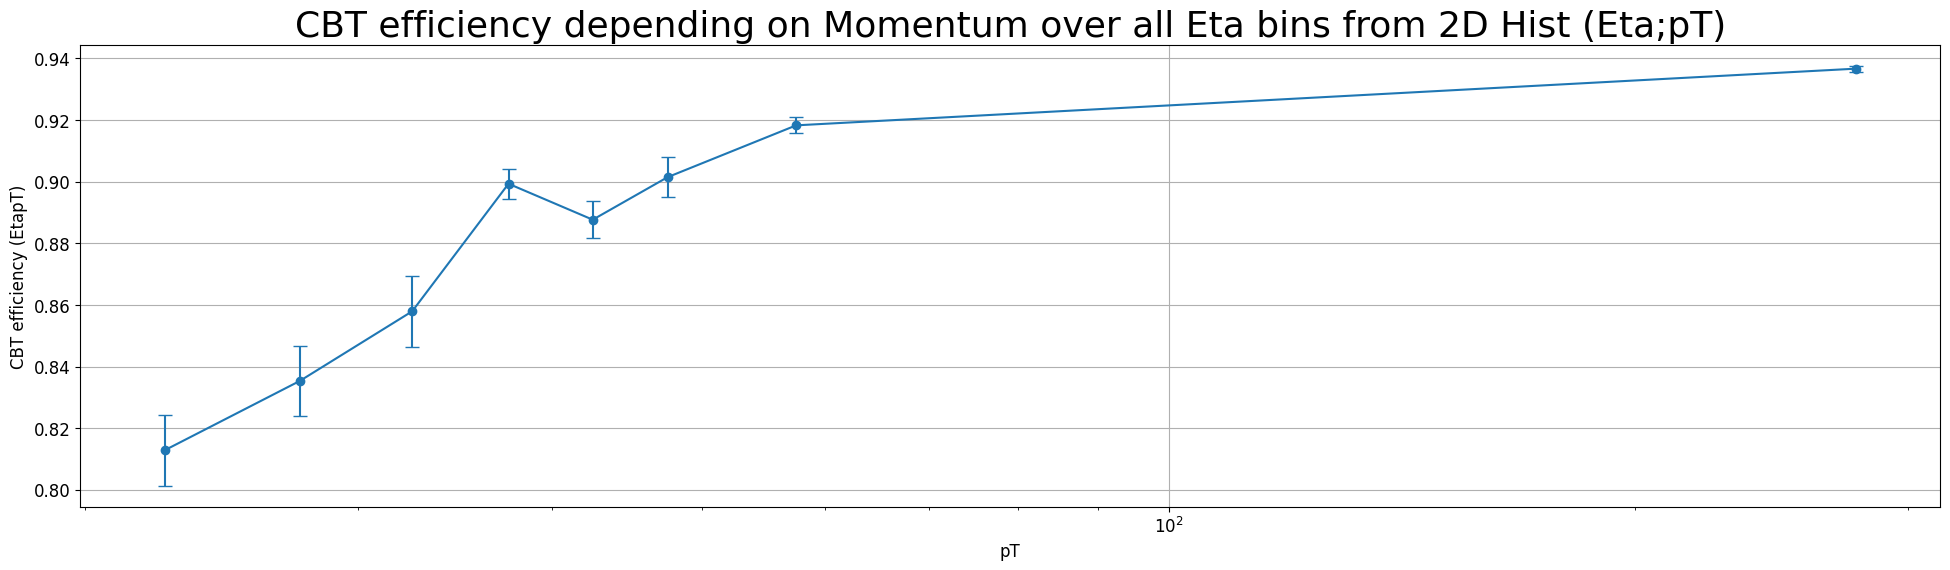

In [23]:
plt.figure(figsize=(24, 6))

plt.errorbar(pt_sig, eff_sig_tight_EtapT[0,:], yerr=efferr_sig_tight_EtapT[0,:], fmt='o-', capsize=5)
plt.xlabel('pT')
plt.xscale('log')
plt.ylabel('CBT efficiency (EtapT)')
plt.title('CBT efficiency depending on Momentum over all Eta bins from 2D Hist (Eta;pT)', fontsize = 26)
plt.grid(True)

plt.show()

## CBT efficiency depending on pT over all bins of Eta from 2D Hist (Eta;pT)

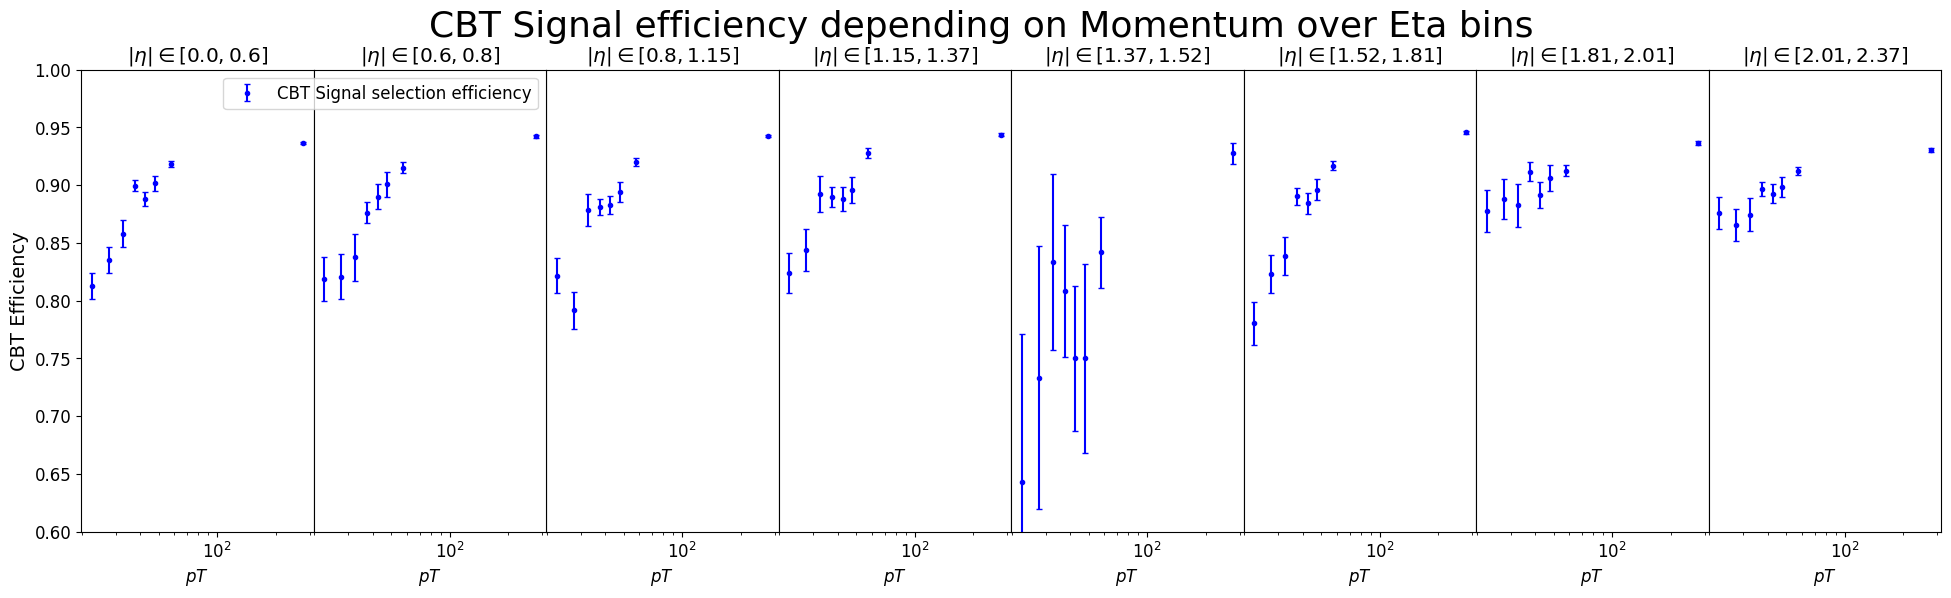

In [24]:
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(24,6))
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(pt_sig, eff_sig_tight_EtapT[i], yerr=efferr_sig_tight_EtapT[i],
        fmt=".", label='CBT Signal selection efficiency', capsize=2, color = 'blue')  
    ax[i].set_xscale('log')
    if (i!=0):
        ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    ax[i].set_xlabel('$pT$')
    ax[i].set_ylim([0.6, 1.0])
    
        
ax[0].set_ylabel("CBT Efficiency",  fontsize=14)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 12)

fig.suptitle('CBT Signal efficiency depending on Momentum over Eta bins', fontsize=26)



#plt.savefig(savedir+"BDT_PID_reject_effi/CBT Signal & Background efficiency depending on Pileup over Eta bins.pdf")
plt.show()

## CBT efficiency depending on Pseudo-rapidity over all other features

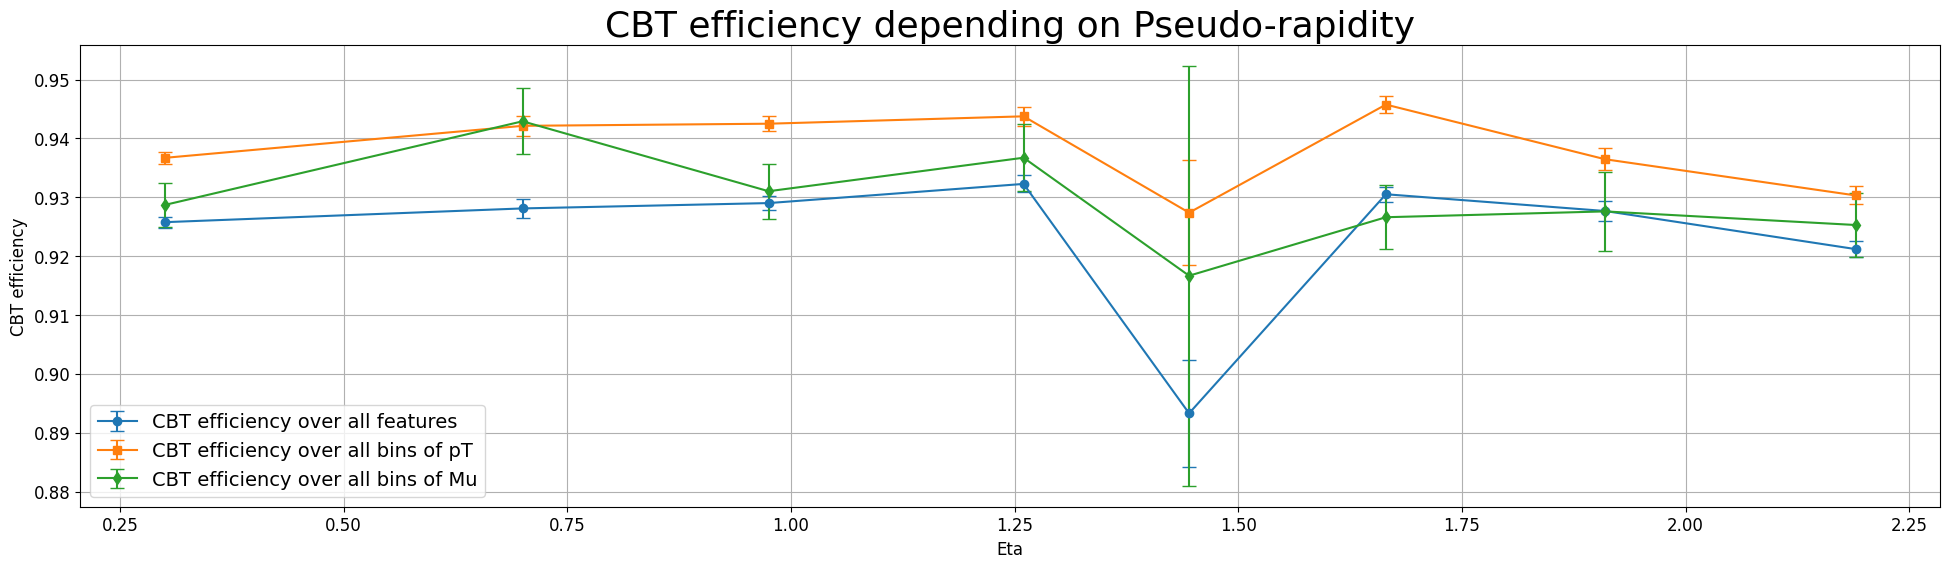

In [25]:

plt.figure(figsize=(24, 6))

plt.errorbar(eta, eff_sig_tight_eta, yerr=efferr_sig_tight_eta, fmt='o-', capsize=5, label='CBT efficiency over all features')

plt.errorbar(eta, eff_sig_tight_EtapT[:, i], yerr=efferr_sig_tight_EtapT[:, i], fmt='s-', capsize=5, label='CBT efficiency over all bins of pT')

plt.errorbar(eta, eff_sig_tight_EtaMu[:, i], yerr=efferr_sig_tight_EtaMu[:, i], fmt='d-', capsize=5, label='CBT efficiency over all bins of Mu')

plt.xlabel('Eta')
plt.ylabel('CBT efficiency')
plt.title('CBT efficiency depending on Pseudo-rapidity', fontsize=26)
plt.grid(True)
plt.legend(loc='best', fontsize=14)

plt.show()

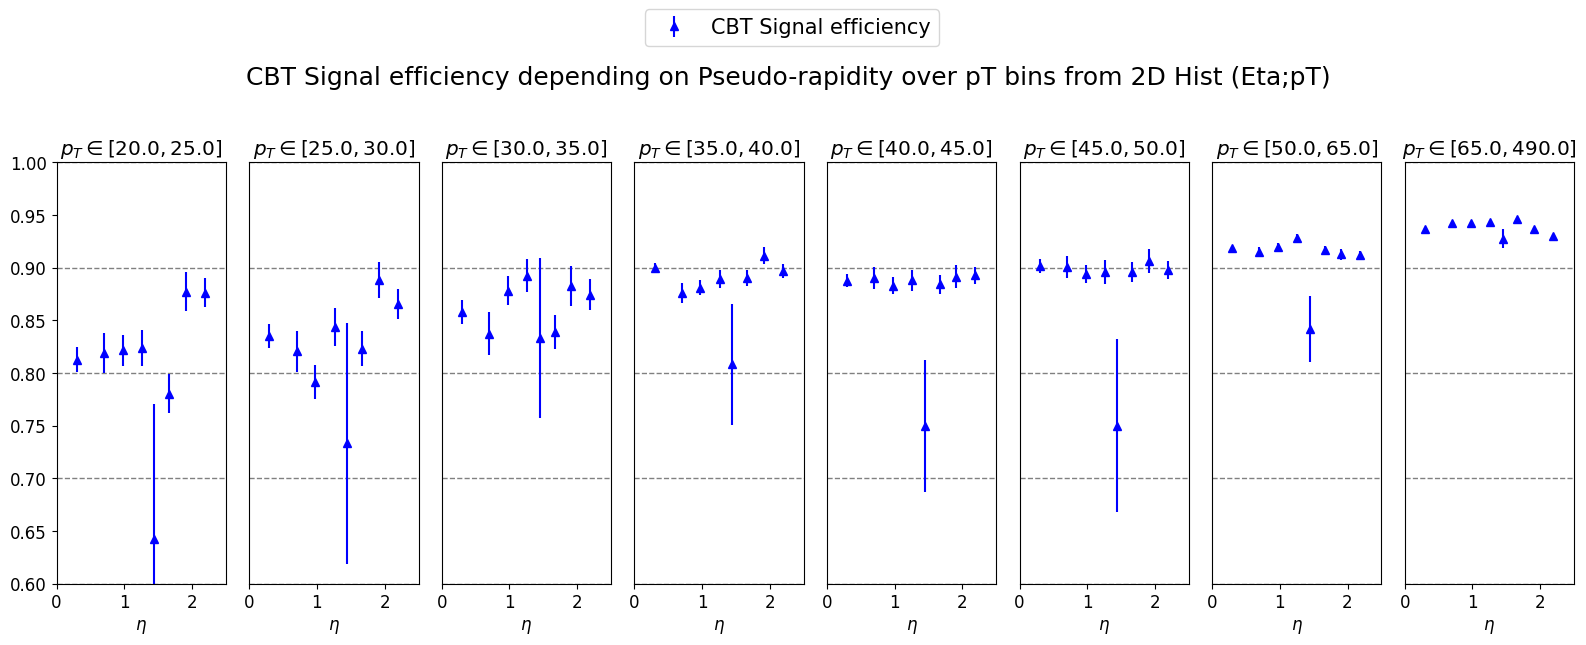

In [26]:
plt.rcParams.update({'font.size': 12})

fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(16, 6))
fig.subplots_adjust(wspace=0.3, hspace=0.4)

handles = []
labels = []

for i in range(8):
    col = i % 10

    # Axe principal
    ax = axes[col]
    
    ax.axhline(y=0.6, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=0.7, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=0.8, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=0.9, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=1.0, color='grey', linestyle='--', linewidth=1)

    errorbar_tight_sig = ax.errorbar(eta, eff_sig_tight_EtapT[:, i], efferr_sig_tight_EtapT[:, i],
                                     fmt="^", label='CBT Signal efficiency', color='blue')

    if i == 0:
        handles.append(errorbar_tight_sig)
        labels.append('CBT Signal efficiency')

    ax.set_title(f"$p_T \in [{edges_pt_sig[i]:.1f}, {edges_pt_sig[i+1]:.1f}]$")
    ax.set_ylim(0.6, 1.0)
    ax.set_xlim([0.0, 2.5])
    if col != 0:
        ax.set_yticks([])

# Étiquettes axes x  dernière rangée de subplots
for col in range(8):
    axes[col].set_xlabel("$\eta$")

fig.suptitle('CBT Signal efficiency depending on Pseudo-rapidity over pT bins from 2D Hist (Eta;pT) ', fontsize=18)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.09), ncol=2, fontsize=15)

plt.tight_layout(rect=[0, 0, 1, 0.96])
#plt.savefig(savedir + "BDT_PID_reject_effi/CBT_Signal_selection_efficiency_WP_Bins(Eta_pT).pdf")
plt.show()

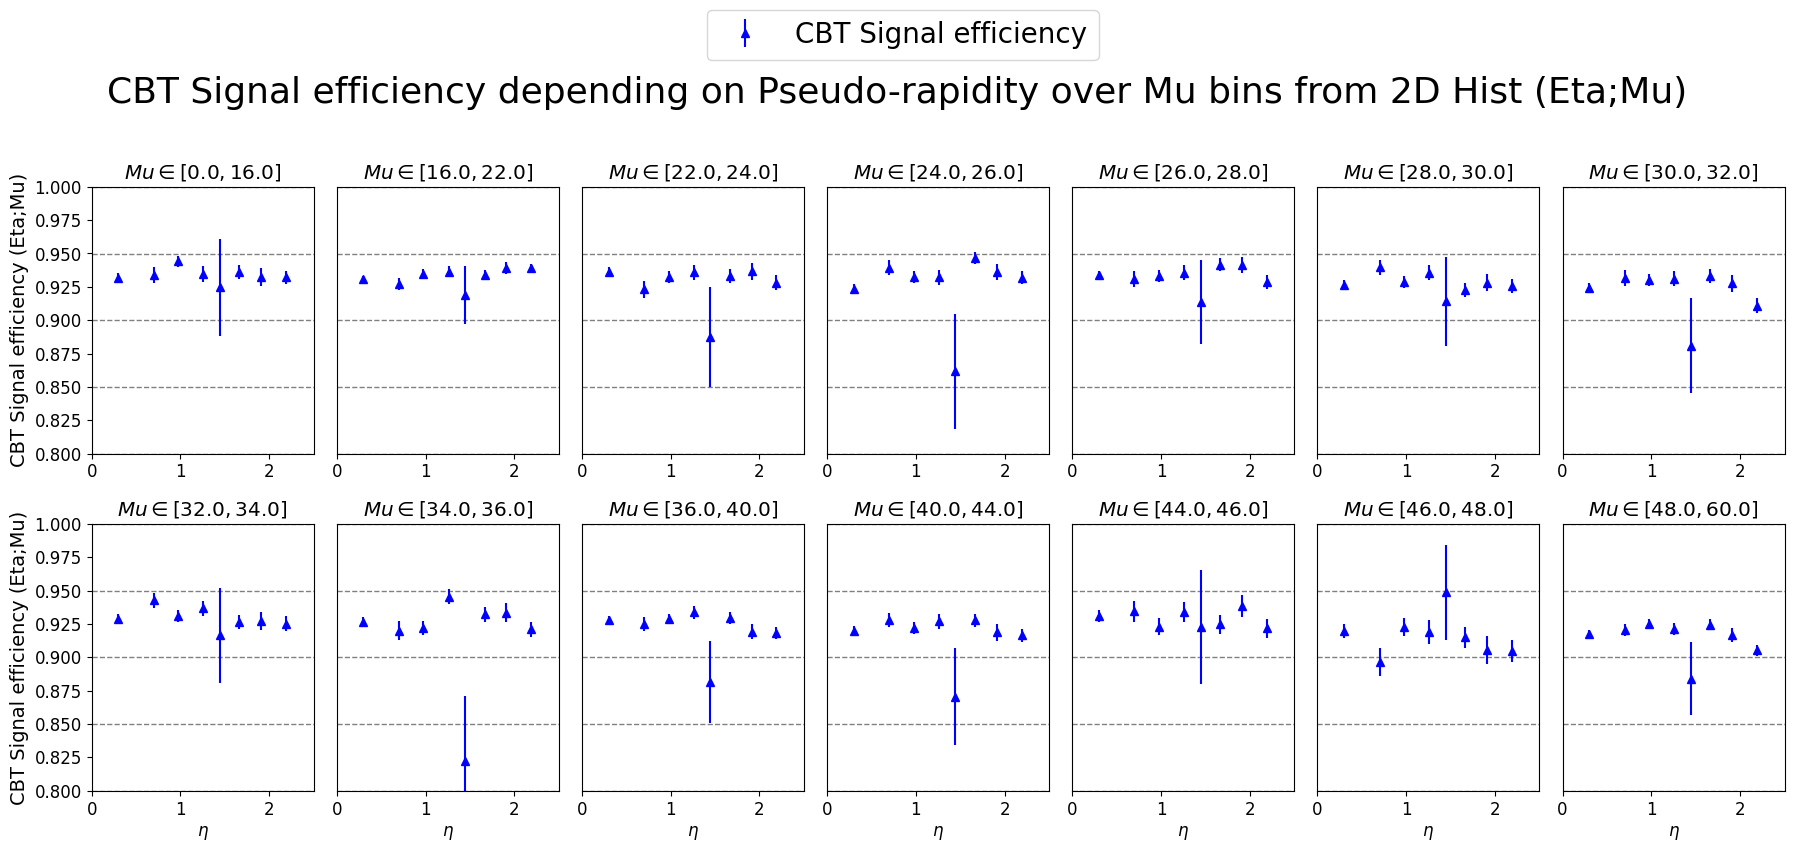

In [27]:
plt.rcParams.update({'font.size': 12})

fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(18, 8))
fig.subplots_adjust(wspace=0.3, hspace=0.4)

handles = []
labels = []

for i in range(14):
    row = i // 7
    col = i % 7

    # Axe principal
    ax = axes[row, col]
    
    ax.axhline(y=0.8, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=0.85, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=0.9, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=0.95, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=1.0, color='grey', linestyle='--', linewidth=1)

    errorbar_tight_sig = ax.errorbar(eta, eff_sig_tight_EtaMu[:, i], efferr_sig_tight_EtaMu[:, i],
                                     fmt="^", label='CBT Signal efficiency', color='blue')

    if i == 0:
        handles.append(errorbar_tight_sig)
        labels.append('CBT Signal efficiency')

    ax.set_title(f"$Mu \in [{edges_mu[i]:.1f}, {edges_mu[i+1]:.1f}]$")
    ax.set_ylim(0.8, 1.0)
    ax.set_xlim([0.0, 2.5])
    if col != 0:
        ax.set_yticks([])

# Étiquettes axes première colonne
for row in range(2):
    axes[row, 0].set_ylabel("CBT Signal efficiency (Eta;Mu)", fontsize=14)

# Étiquettes axes x  dernière rangée de subplots
for col in range(7):
    axes[-1, col].set_xlabel("$\eta$")

fig.suptitle('CBT Signal efficiency depending on Pseudo-rapidity over Mu bins from 2D Hist (Eta;Mu) ', fontsize=26)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=2, fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.96])
#plt.savefig(savedir + "BDT_PID_reject_effi/CBT_Signal_selection_efficiency_WP_Bins(Eta_pT).pdf")
plt.show()

# BDT working point optimization
Optimiser le point de fonctionnement d'un modèle BDT (Boosted Decision Trees) en calculant un seuil de score qui atteint une efficacité cible donnée.

In [33]:
def compute_eff_BDT(df, threshold):
    '''Return efficienty of a given selection on BDT score'''
    r = (df['Original_signal_score'] > threshold).sum() / len(df) # 'threshold' -> Le seuil du score BDT utilisé pour déterminer 
                                                                    # si un événement est sélectionné.

#  (df['Addevtmu_signal_score'] > threshold) : 
#  Crée une série booléenne où chaque élément est True si le score BDT de l'événement correspondant est supérieur au seuil donné,
#  sinon False.
#  .sum() : 
#  Compte le nombre de True dans la série booléenne, ce qui équivaut au nombre d'événements passant le seuil.
#  /len(df) : 
#  Pour obtenir l'efficacité de la sélection.  
    
    return r   # Efficacité de la sélection.

Trouve le seuil de score BDT qui permet d'atteindre une efficacité cible spécifique:

In [34]:
def find_cut_with_root_scalar(df, target_efficiency):
    '''Find selection on BDT score correponsing to target effeciency'''
    
#  scipy.optimize.root_scalar(....) :
#  Fonction de SciPy qui cherche une racine d'une fonction univariée. Ici, elle cherche le seuil x où l'efficacité de 
#  sélection est égale à l'efficacité cible.  
  
    r = scipy.optimize.root_scalar(                
        lambda x: compute_eff_BDT(df, x) - target_efficiency, bracket=(0., 1.0), #  Scores BDT sont normalisés entre 0 et 1.
        
#  lambda x: compute_eff_BDT(df, x) - target_efficiency :
#  Fonction anonyme (lambda) qui calcule la différence entre l'efficacité obtenue pour un seuil donné x et l'efficacité cible. 
#  Cette fonction est utilisée pour trouver la racine (c'est-à-dire le seuil où la différence est zéro).
        
        method='brenth', options={'xtol': 1E-5, 'maxiter': 50}
    )

#  method='brenth' : 
#  méthode sécurisée qui combine la méthode de la bissection, la méthode des cordes et l'inversion quadratique.
    
#  'xtol': 1E-5, 'maxiter': 50 :
#   Définit la tolérance sur la solution (précision) et le nombre maximum d'itérations pour trouver la racine. 
    
    return r.root

# r.root est l'attribut de l'objet résultat retourné par root_scalar contenant la solution trouvée.

# WP parametré sur Eta et Mu

In [35]:
df_bkg_indexed_WPEtaMu = df_bkg.set_index(['mu_bin_bkg', 'eta_bin_bkg']).sort_index()

#df_bkg_indexed_WPEtaMu

In [36]:
bdt_cut_same_background_efficiency_tight_WPEtaMu = {} # store optimal BDT thresholds

for (ieta, imu), eff_tight in np.ndenumerate(eff_bkg_tight_EtaMu): 
    # select subsample of events corresponding to the current (eta, mu) bin
    
    df_bin = df_bkg_indexed_WPEtaMu.loc[imu, ieta] # using indexed df to speedup selection
    
    # find and store optimal BDT selection for current bin
    cut_BDT = find_cut_with_root_scalar(df_bin, target_efficiency=eff_tight)
    bdt_cut_same_background_efficiency_tight_WPEtaMu[imu, ieta] = cut_BDT

bdt_cut_same_background_efficiency_tight_WPEtaMu = pd.Series(bdt_cut_same_background_efficiency_tight_WPEtaMu).sort_index()
bdt_cut_same_background_efficiency_tight_WPEtaMu.index.names = ['mu_bin_bkg', 'eta_bin_bkg']

#bdt_cut_same_background_efficiency_tight_WPEtaMu

In [37]:
df = df.merge(bdt_cut_same_background_efficiency_tight_WPEtaMu.rename('BDTcut_samebkgeff_tight'), 
             on=['mu_bin_bkg', 'eta_bin_bkg'], how="left")
df = df.assign(pass_BDTcut_samebkgeff_tight_WPEtaMu = df['Original_signal_score'] > df['BDTcut_samebkgeff_tight'])

In [38]:
df.drop('BDTcut_samebkgeff_tight',axis=1,inplace=True)
#df.head()

### Compute efficiency and rejection for BDT working point

In [39]:
df_sig = df.query('truth_label == 1')
df_bkg = df.query('truth_label == 0')
# df_sig.head(5)

In [40]:
#num and efficiency for the BDT

df_sig_bdt_EtaMu_WPEtaMu = df_sig.query('pass_BDTcut_samebkgeff_tight_WPEtaMu')
num_sig_bdt_EtaMu_WPEtaMu = hist.Hist(axis_eta, axis_mu).fill(df_sig_bdt_EtaMu_WPEtaMu["y_abs_eta"], df_sig_bdt_EtaMu_WPEtaMu["evt_mu"])

df_bkg_bdt_EtaMu_WPEtaMu = df_bkg.query('pass_BDTcut_samebkgeff_tight_WPEtaMu')
num_bkg_bdt_EtaMu_WPEtaMu = hist.Hist(axis_eta, axis_mu).fill(df_bkg_bdt_EtaMu_WPEtaMu["y_abs_eta"], df_bkg_bdt_EtaMu_WPEtaMu["evt_mu"])

eff_sig_bdt_EtaMu_WPEtaMu = (num_sig_bdt_EtaMu_WPEtaMu / den_sig_EtaMu).values()
efferr_sig_bdt_EtaMu_WPEtaMu = np.sqrt(eff_sig_bdt_EtaMu_WPEtaMu * (1 - eff_sig_bdt_EtaMu_WPEtaMu) / den_sig_EtaMu.values())

eff_bkg_bdt_EtaMu_WPEtaMu = (num_bkg_bdt_EtaMu_WPEtaMu / den_bkg_EtaMu).values()
efferr_bkg_bdt_EtaMu_WPEtaMu = np.sqrt(eff_bkg_bdt_EtaMu_WPEtaMu * (1 - eff_bkg_bdt_EtaMu_WPEtaMu) / den_bkg_EtaMu.values())

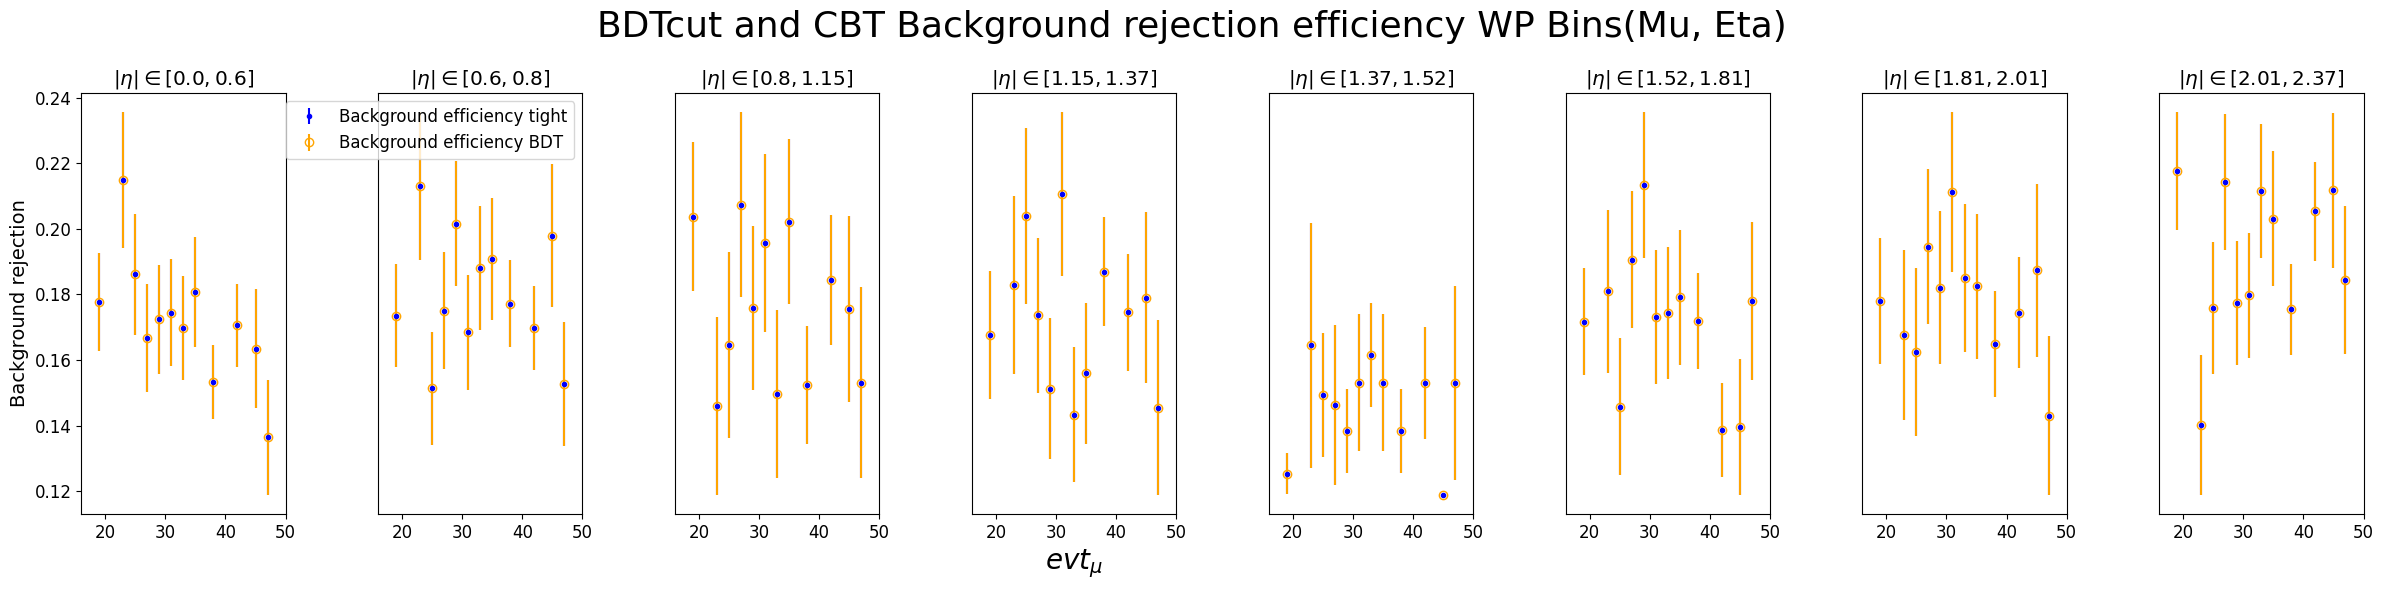

In [41]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(24,6))
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(mu, eff_bkg_tight_EtaMu[i],efferr_bkg_tight_EtaMu[i],
                   fmt=".", label='Background efficiency tight', color = 'blue')
    ax[i].errorbar(mu, eff_bkg_bdt_EtaMu_WPEtaMu[i],efferr_bkg_bdt_EtaMu_WPEtaMu[i],
                   fmt="o", fillstyle='none', label='Background efficiency BDT', color = 'orange')    
    #ax[i].set_xscale('log')
    if (i!=0): ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    ax[i].set_xlim([16, 50])
    
ax[0].set_ylabel("Background rejection",  fontsize=14)
ax[3].set_xlabel("$evt_{\mu}$",  fontsize=20)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 12)
fig.suptitle('BDTcut and CBT Background rejection efficiency WP Bins(Mu, Eta)', fontsize=26)

plt.tight_layout()

#plt.savefig(savedir+"BDT_PID_reject_effi/BDTcut and CBT Background rejection efficiency WP Bins(Mu, Eta).pdf")
plt.show()

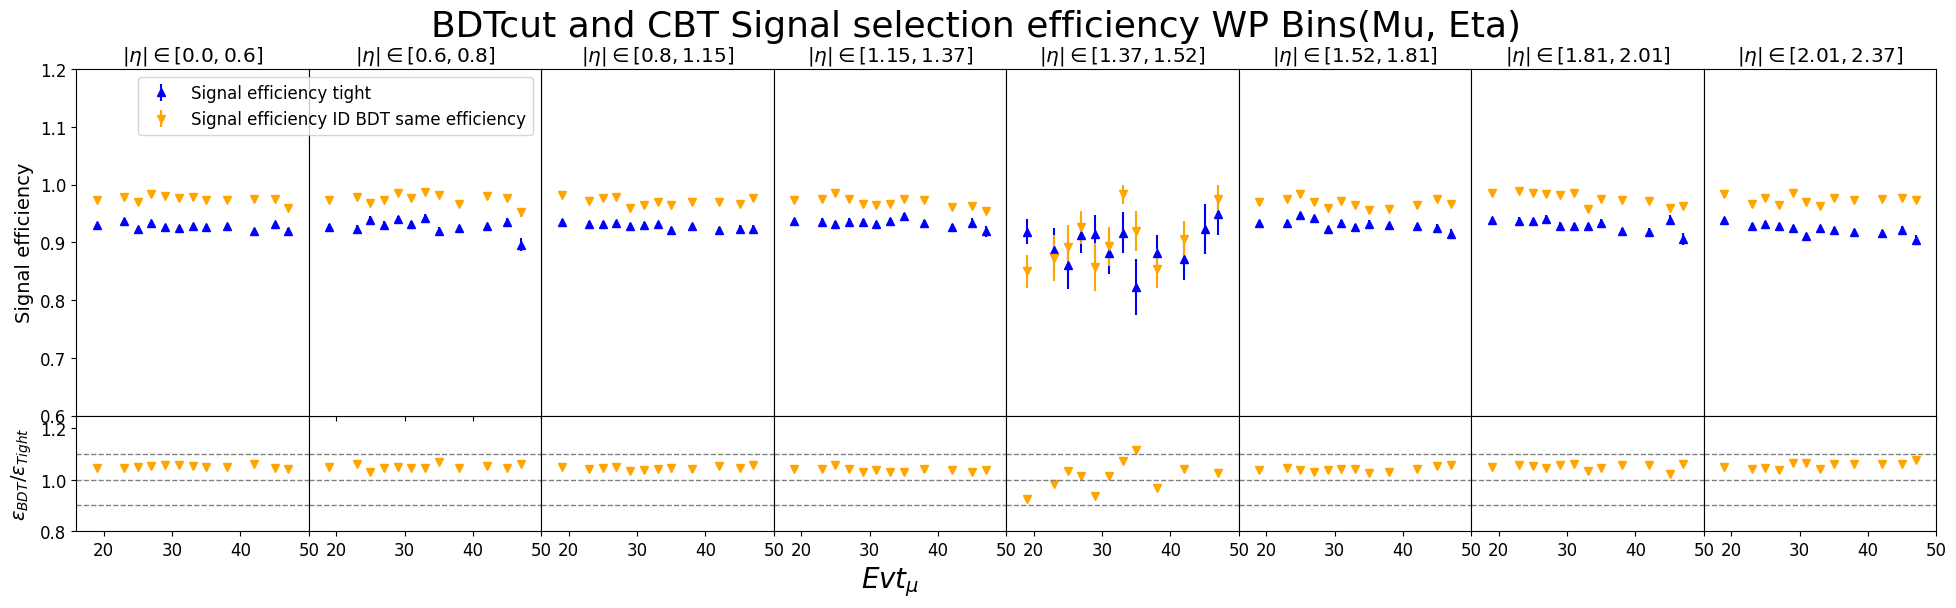

In [42]:
plt.rcParams.update({'font.size': 12})

fig, (ax, rax) = plt.subplots(nrows=2, ncols=8, figsize=(24,6), 
                              gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(mu, eff_sig_tight_EtaMu[i], efferr_sig_tight_EtaMu[i],
        fmt="^", label='Signal efficiency tight', color = 'blue')
    ax[i].errorbar(mu, eff_sig_bdt_EtaMu_WPEtaMu[i], efferr_sig_bdt_EtaMu_WPEtaMu[i],
        fmt="v", label='Signal efficiency ID BDT same efficiency', color = 'orange')    
    #ax[i].set_xscale('log')
    if (i!=0):
        ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    rax[i].plot(mu, eff_sig_bdt_EtaMu_WPEtaMu[i]/eff_sig_tight_EtaMu[i], 'v', color = 'orange')
    rax[i].axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=0.9, color='grey', linestyle='--', linewidth=1)
    rax[i].set_xlim([16, 50])
    rax[i].set_ylim([0.8, 1.25])
    ax[i].set_ylim([0.6, 1.2])
    if (i!=0):
        rax[i].set_yticks([])
        
rax[0].set_ylabel(r'$\epsilon_{BDT}$/$\epsilon_{Tight}$', fontsize=14)
ax[0].set_ylabel("Signal efficiency",  fontsize=14)
rax[3].set_xlabel("$Evt_{\mu}$",  fontsize=20)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 12)

fig.suptitle('BDTcut and CBT Signal selection efficiency WP Bins(Mu, Eta)', fontsize=26)



#plt.savefig(savedir+"BDT_PID_reject_effi/BDTcut and CBT Signal selection efficiency WP Bins(Mu, Eta).pdf")
plt.show()

### Importation du modéle BDT avec Evt_mu dans les variables d'entrainements

In [40]:
df_WP_MuEta_optimize_AddevtMu_signalscore = pd.read_pickle("/home/chardong/y_identification/Venv/save_pkl/df_WP(Mu_Eta)_optimize_AddevtMu_signalscore.pkl")

In [41]:
df_WP_MuEta_optimize_AddevtMu_signalscore_sig = df.query('truth_label == 1')
df_WP_MuEta_optimize_AddevtMu_signalscore_bkg = df.query('truth_label == 0')

In [42]:
#num and efficiency for the BDT
df_sig_AddMubdt_WPEtaMu = df_WP_MuEta_optimize_AddevtMu_signalscore_sig.query('pass_BDTcut_samebkgeff_tight_WPEtaMu')
num_sig_AddMubdt_WPEtaMu = hist.Hist(axis_eta, axis_mu).fill(df_sig_AddMubdt_WPEtaMu["y_abs_eta"], df_sig_AddMubdt_WPEtaMu["evt_mu"])

df_bkg_AddMubdt_WPEtaMu = df_WP_MuEta_optimize_AddevtMu_signalscore_bkg.query('pass_BDTcut_samebkgeff_tight_WPEtaMu')
num_bkg_AddMubdt_WPEtaMu = hist.Hist(axis_eta, axis_mu).fill(df_bkg_AddMubdt_WPEtaMu["y_abs_eta"], df_bkg_AddMubdt_WPEtaMu["evt_mu"])

In [43]:
eff_sig_AddMubdt_WPEtaMu, efferr_sig_AddMubdt_WPEtaMu = efficiency(num_sig_AddMubdt_WPEtaMu, den_sig_EtaMu)
eff_bkg_AddMubdt_WPEtaMu, efferr_bkg_AddMubdt_WPEtaMu = efficiency(num_bkg_AddMubdt_WPEtaMu, den_bkg_EtaMu)

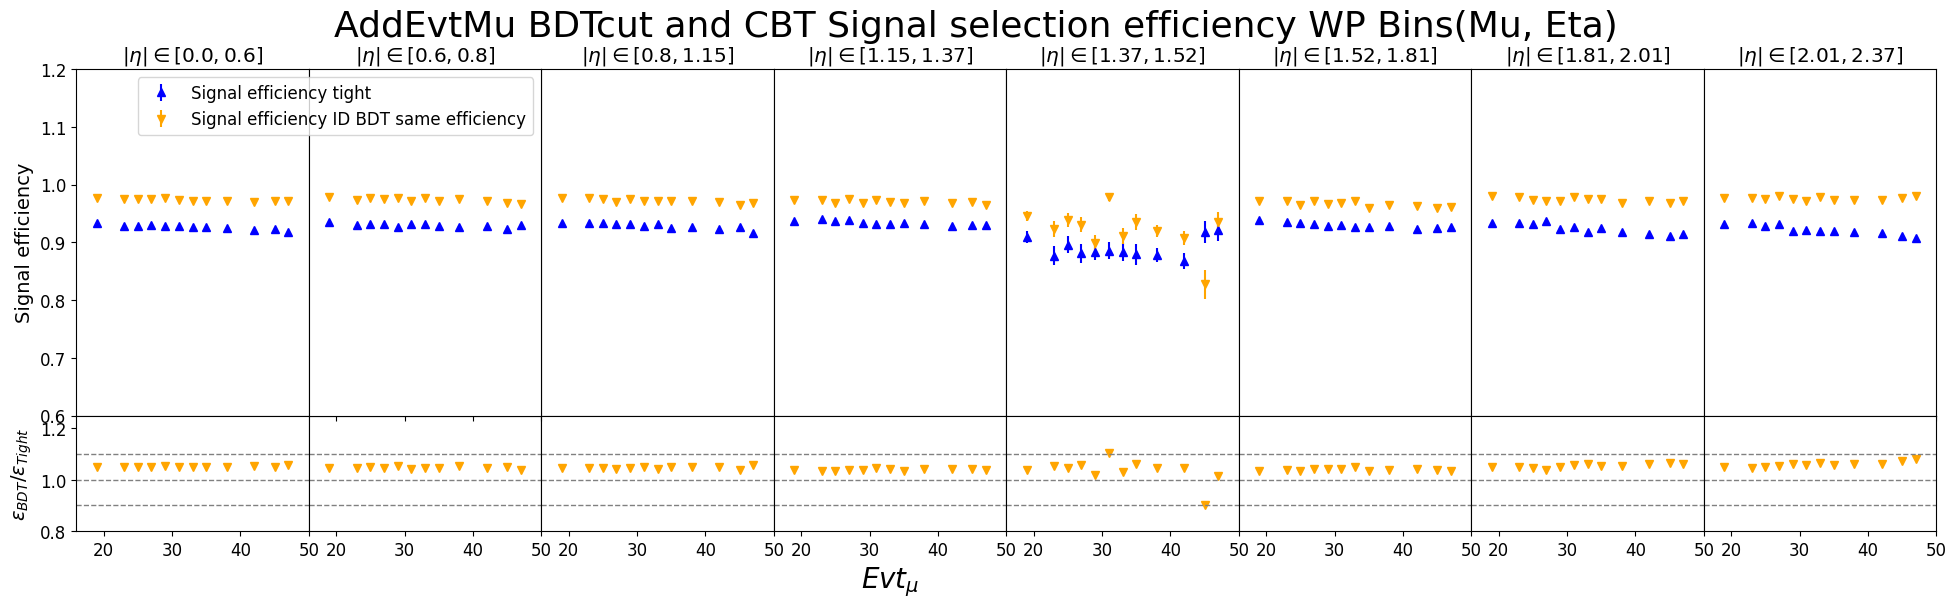

In [44]:
plt.rcParams.update({'font.size': 12})

fig, (ax, rax) = plt.subplots(nrows=2, ncols=8, figsize=(24,6), 
                              gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(mu, eff_sig_tight_EtaMu[i], efferr_sig_tight_EtaMu[i],
        fmt="^", label='Signal efficiency tight', color = 'blue')
    ax[i].errorbar(mu, eff_sig_AddMubdt_WPEtaMu[i], efferr_sig_AddMubdt_WPEtaMu[i],
        fmt="v", label='Signal efficiency ID BDT same efficiency', color = 'orange')    
    #ax[i].set_xscale('log')
    if (i!=0):
        ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    rax[i].plot(mu, eff_sig_AddMubdt_WPEtaMu[i]/eff_sig_tight_EtaMu[i], 'v', color = 'orange')
    rax[i].axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=0.9, color='grey', linestyle='--', linewidth=1)
    rax[i].set_xlim([16, 50])
    rax[i].set_ylim([0.8, 1.25])
    ax[i].set_ylim([0.6, 1.2])
    if (i!=0):
        rax[i].set_yticks([])
        
rax[0].set_ylabel(r'$\epsilon_{BDT}$/$\epsilon_{Tight}$', fontsize=14)
ax[0].set_ylabel("Signal efficiency",  fontsize=14)
rax[3].set_xlabel("$Evt_{\mu}$",  fontsize=20)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 12)

fig.suptitle('AddEvtMu BDTcut and CBT Signal selection efficiency WP Bins(Mu, Eta)', fontsize=26)



#plt.savefig(savedir+"BDT_PID_reject_effi/AddEvtMu BDTcut and CBT Signal selection efficiency WP Bins(Mu, Eta).pdf")
plt.show()

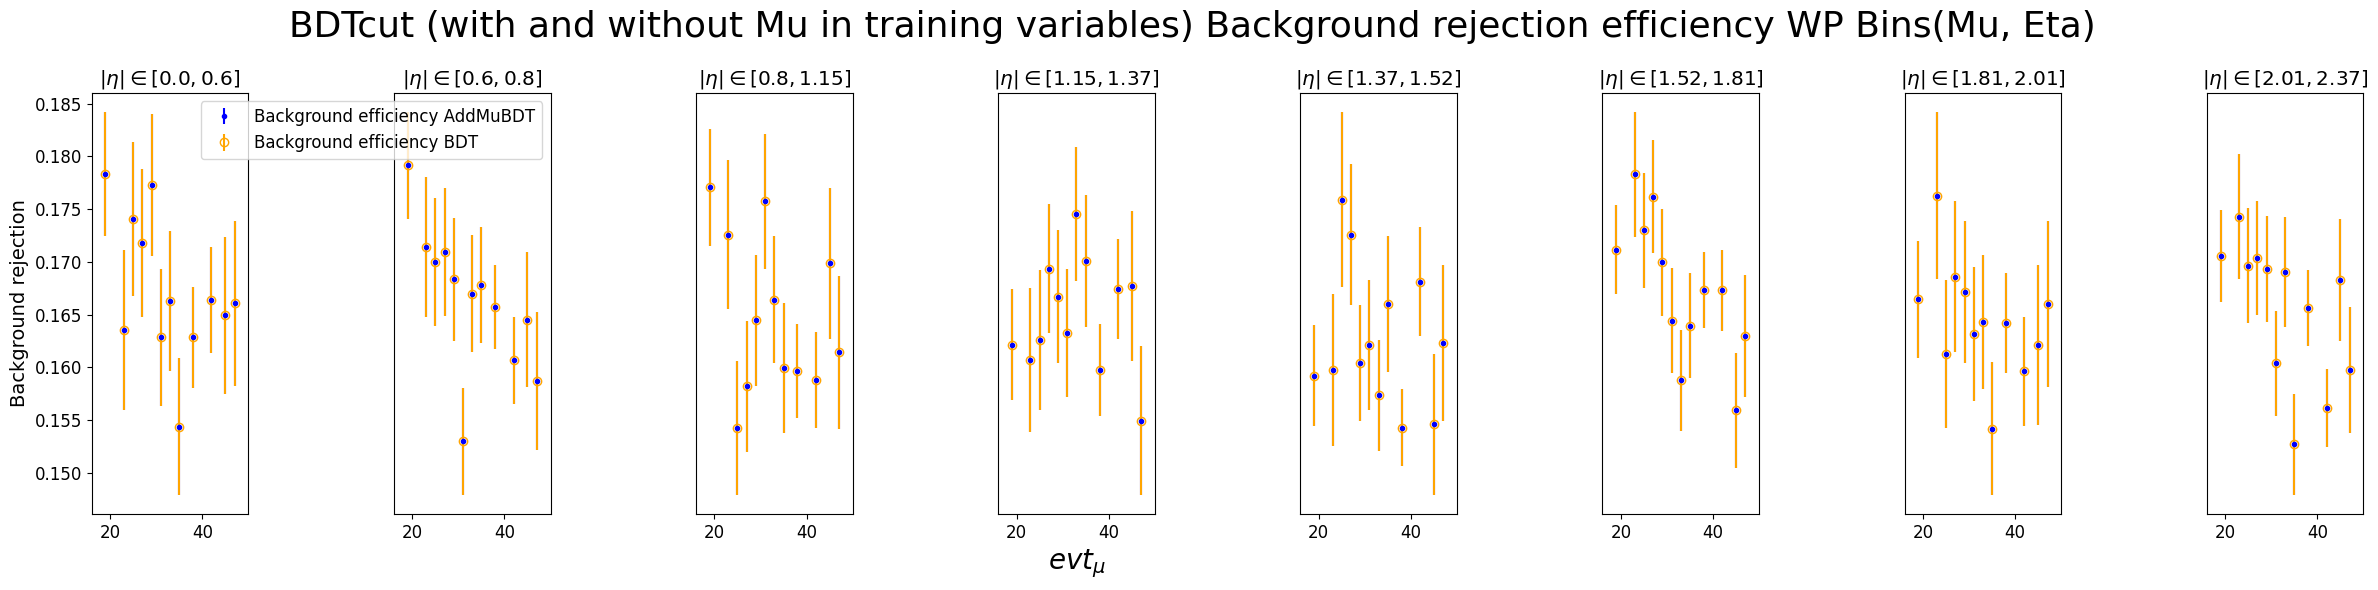

In [45]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(24,6))
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(mu, eff_bkg_AddMubdt_WPEtaMu[i],efferr_bkg_AddMubdt_WPEtaMu[i],
                   fmt=".", label='Background efficiency AddMuBDT', color = 'blue')
    ax[i].errorbar(mu, eff_bkg_bdt_EtaMu_WPEtaMu[i],efferr_bkg_bdt_EtaMu_WPEtaMu[i],
                   fmt="o", fillstyle='none', label='Background efficiency BDT', color = 'orange')    
    #ax[i].set_xscale('log')
    if (i!=0): ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    ax[i].set_xlim([16, 50])
    
ax[0].set_ylabel("Background rejection",  fontsize=14)
ax[3].set_xlabel("$evt_{\mu}$",  fontsize=20)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 12)
fig.suptitle('BDTcut (with and without Mu in training variables) Background rejection efficiency WP Bins(Mu, Eta)', fontsize=26)

plt.tight_layout()

#plt.savefig(savedir+"BDT_PID_reject_effi/BDTcut (with and without Mu in training variables) Background rejection efficiency WP Bins(Mu, Eta).pdf")
plt.show()

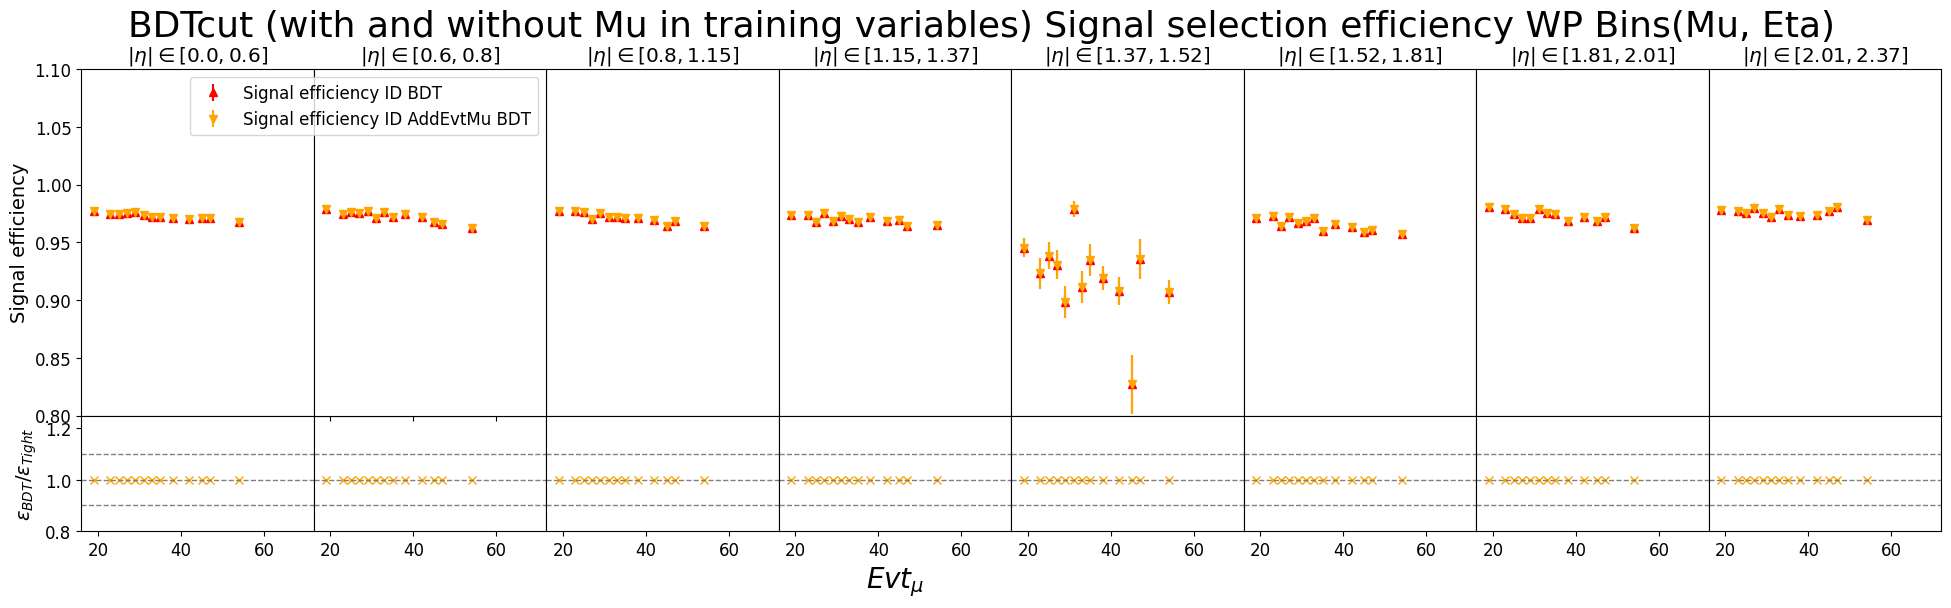

In [46]:
plt.rcParams.update({'font.size': 12})

fig, (ax, rax) = plt.subplots(nrows=2, ncols=8, figsize=(24,6), 
                              gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(mu, eff_sig_bdt_EtaMu_WPEtaMu[i], efferr_sig_bdt_EtaMu_WPEtaMu[i],
        fmt="^", label='Signal efficiency ID BDT', color = 'red')
    ax[i].errorbar(mu, eff_sig_AddMubdt_WPEtaMu[i], efferr_sig_AddMubdt_WPEtaMu[i],
        fmt="v", label='Signal efficiency ID AddEvtMu BDT', color = 'orange')    
    #ax[i].set_xscale('log')
    if (i!=0):
        ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    rax[i].plot(mu, eff_sig_AddMubdt_WPEtaMu[i]/eff_sig_bdt_EtaMu_WPEtaMu[i], 'x', color = 'orange')
    rax[i].axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=0.9, color='grey', linestyle='--', linewidth=1)
    rax[i].set_xlim([16, 72])
    rax[i].set_ylim([0.8, 1.25])
    ax[i].set_ylim([0.8, 1.1])
    if (i!=0):
        rax[i].set_yticks([])
        
rax[0].set_ylabel(r'$\epsilon_{BDT}$/$\epsilon_{Tight}$', fontsize=14)
ax[0].set_ylabel("Signal efficiency",  fontsize=14)
rax[3].set_xlabel("$Evt_{\mu}$",  fontsize=20)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 12)

fig.suptitle('BDTcut (with and without Mu in training variables) Signal selection efficiency WP Bins(Mu, Eta)', fontsize=26)



#plt.savefig(savedir+"BDT_PID_reject_effi/BDTcut (with and without Mu in training variables) Signal selection efficiency WP Bins(Mu, Eta).pdf")
plt.show()

# BDT pour WP Eta Mu

In [47]:
#num and efficiency for the BDT

df_sig_bdt_EtapT_WPEtaMu = df_sig.query('pass_BDTcut_samebkgeff_tight_WPEtaMu')
num_sig_bdt_EtapT_WPEtaMu = hist.Hist(axis_eta, axis_pt_sig).fill(df_sig_bdt_EtapT_WPEtaMu["y_abs_eta"], df_sig_bdt_EtapT_WPEtaMu["y_pt"])

df_bkg_bdt_EtapT_WPEtaMu = df_sig.query('pass_BDTcut_samebkgeff_tight_WPEtaMu')
num_bkg_bdt_EtapT_WPEtaMu = hist.Hist(axis_eta, axis_pt_bkg).fill(df_bkg_bdt_EtapT_WPEtaMu["y_abs_eta"], df_bkg_bdt_EtapT_WPEtaMu["y_pt"])

In [48]:
eff_sig_bdt_EtapT_WPEtaMu, efferr_sig_bdt_EtapT_WPEtaMu = efficiency(num_sig_bdt_EtapT_WPEtaMu, den_sig_EtapT)
eff_bkg_bdt_EtapT_WPEtaMu, efferr_bkg_bdt_EtapT_WPEtaMu = efficiency(num_bkg_bdt_EtapT_WPEtaMu, den_bkg_EtapT)

/tmp/ipykernel_138107/3610677414.py:3: RuntimeWarning: invalid value encountered in sqrt
  efferr = np.sqrt(eff*(1.-eff)/den.values())


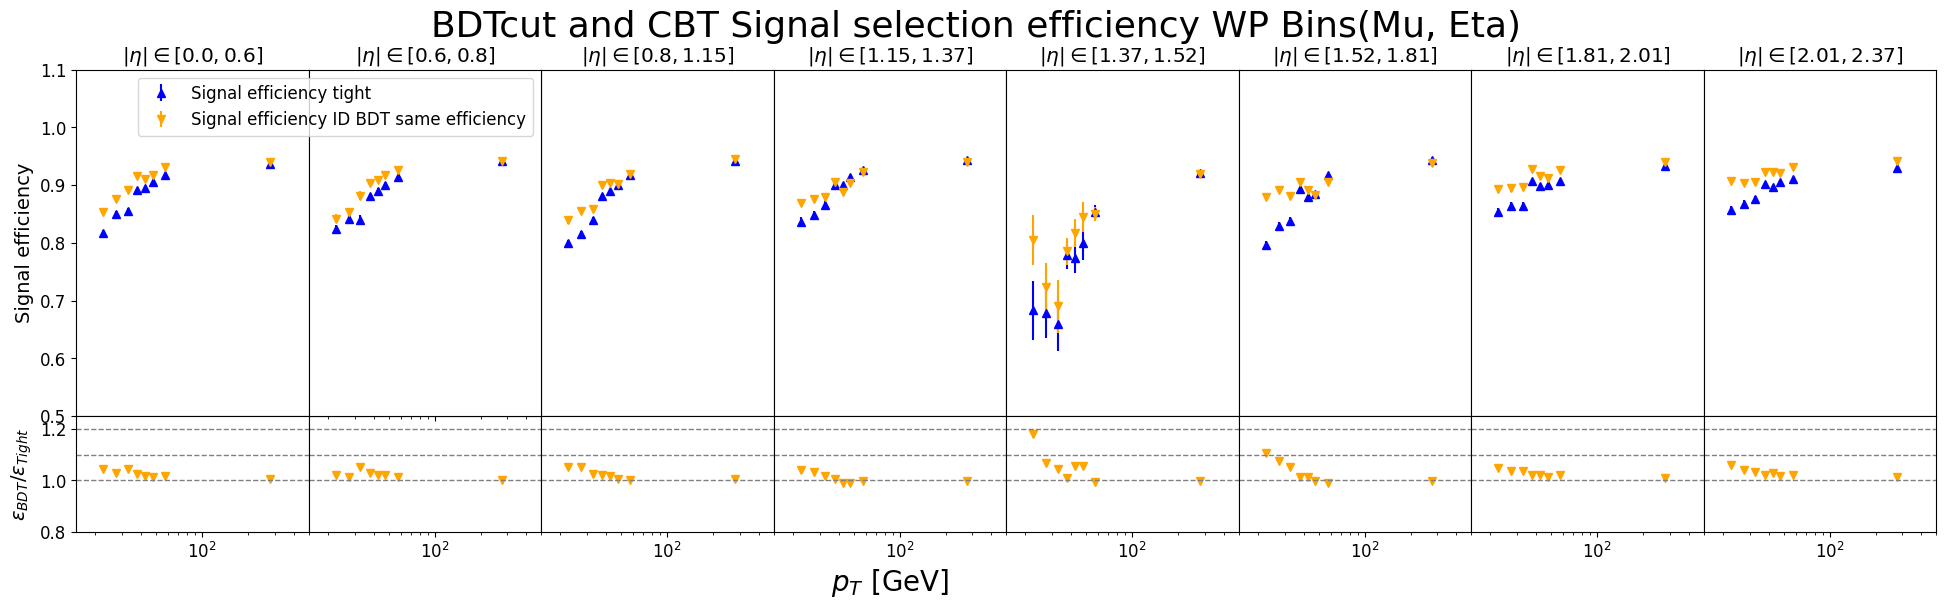

In [49]:
plt.rcParams.update({'font.size': 12})

fig, (ax, rax) = plt.subplots(nrows=2, ncols=8, figsize=(24,6), 
                              gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(pt_sig, eff_sig_tight_EtapT[i], efferr_sig_tight_EtapT[i],
        fmt="^", label='Signal efficiency tight', color = 'blue')
    ax[i].errorbar(pt_sig, eff_sig_bdt_EtapT_WPEtaMu[i], efferr_sig_bdt_EtapT_WPEtaMu[i],
        fmt="v", label='Signal efficiency ID BDT same efficiency', color = 'orange')    
    ax[i].set_xscale('log')
    if (i!=0):
        ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    rax[i].plot(pt_sig, eff_sig_bdt_EtapT_WPEtaMu[i]/eff_sig_tight_EtapT[i], 'v', color = 'orange')
    rax[i].axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=1.2, color='grey', linestyle='--', linewidth=1)
    rax[i].set_xlim([15, 5*10**2])
    rax[i].set_ylim([0.8, 1.25])
    ax[i].set_ylim([0.5, 1.1])
    if (i!=0):
        rax[i].set_yticks([])
        
rax[0].set_ylabel(r'$\epsilon_{BDT}$/$\epsilon_{Tight}$', fontsize=14)
ax[0].set_ylabel("Signal efficiency",  fontsize=14)
rax[3].set_xlabel("$p_{T}$ [GeV]",  fontsize=20)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 12)

fig.suptitle('BDTcut and CBT Signal selection efficiency WP Bins(Mu, Eta)', fontsize=26)

#plt.savefig(savedir+"BDTcut and CBT Signal selection efficiency WP Bins(Mu, Eta).pdf")
plt.show()

# WP parametré sur Eta et pt

In [50]:
df_bkg_indexed_WPEtapT = df_bkg.set_index(['pt_bin_bkg', 'eta_bin_bkg']).sort_index()
#df_bkg_indexed_WPEtapT

In [51]:
# Search for optimal selection onBDT score separately in all $\eta$ and $p_T$ bins, so that the background efficiency (rejection) is the same as the that provided by thr cut-based Tight selection

bdt_cut_same_background_efficiency_tight_WPEtapT = {} # store optimal BDT thresholds

for (ieta, ipt), eff_tight in np.ndenumerate(eff_bkg_tight_EtapT): 
    # select subsample of events corresponding to the current (eta,pT) bin
    df_bin = df_bkg_indexed_WPEtapT.loc[ipt, ieta] # using indexed df to speedup selection
    # find and store optimal BDT selection for current bin
    cut_BDT = find_cut_with_root_scalar(df_bin, target_efficiency=eff_tight)
    bdt_cut_same_background_efficiency_tight_WPEtapT[ipt, ieta] = cut_BDT

bdt_cut_same_background_efficiency_tight_WPEtapT = pd.Series(bdt_cut_same_background_efficiency_tight_WPEtapT).sort_index()
bdt_cut_same_background_efficiency_tight_WPEtapT.index.names = ['pt_bin_bkg', 'eta_bin_bkg']

#bdt_cut_same_background_efficiency_tight_WPEtapT

pt_bin_bkg  eta_bin_bkg
0           0              0.771494
            1              0.762030
            2              0.773302
            3              0.707726
            4              0.766098
                             ...   
7           3              0.660194
            4              0.577552
            5              0.630273
            6              0.790649
            7              0.761829
Length: 64, dtype: float64

In [52]:
df = df.merge(bdt_cut_same_background_efficiency_tight_WPEtapT.rename('BDTcut_samebkgeff_tight'), 
             on=['pt_bin_bkg', 'eta_bin_bkg'], how="left")
df = df.assign(pass_BDTcut_samebkgeff_tight_WPEtapT = df['Original_signal_score'] > df['BDTcut_samebkgeff_tight'])


df.drop('BDTcut_samebkgeff_tight',axis=1,inplace=True)
#df.head()

In [53]:
# ### Compute efficiency and rejection for BDT working point
df_sig = df.query('truth_label == 1')
df_bkg = df.query('truth_label == 0')
#df_sig.head(5)

In [54]:
#num and efficiency for the BDT

df_sig_bdt_EtapT_WPEtapT = df_sig.query('pass_BDTcut_samebkgeff_tight_WPEtapT')
num_sig_bdt_EtapT_WPEtapT = hist.Hist(axis_eta, axis_pt_sig).fill(df_sig_bdt_EtapT_WPEtapT["y_abs_eta"], df_sig_bdt_EtapT_WPEtapT["y_pt"])

df_bkg_bdt_EtapT_WPEtapT = df_bkg.query('pass_BDTcut_samebkgeff_tight_WPEtapT')
num_bkg_bdt_EtapT_WPEtapT = hist.Hist(axis_eta, axis_pt_bkg).fill(df_bkg_bdt_EtapT_WPEtapT["y_abs_eta"], df_bkg_bdt_EtapT_WPEtapT["y_pt"])

In [55]:
eff_sig_bdt_EtapT_WPEtapT, efferr_sig_bdt_EtapT_WPEtapT = efficiency(num_sig_bdt_EtapT_WPEtapT, den_sig_EtapT)
eff_bkg_bdt_EtapT_WPEtapT, efferr_bkg_bdt_EtapT_WPEtapT = efficiency(num_bkg_bdt_EtapT_WPEtapT, den_bkg_EtapT)

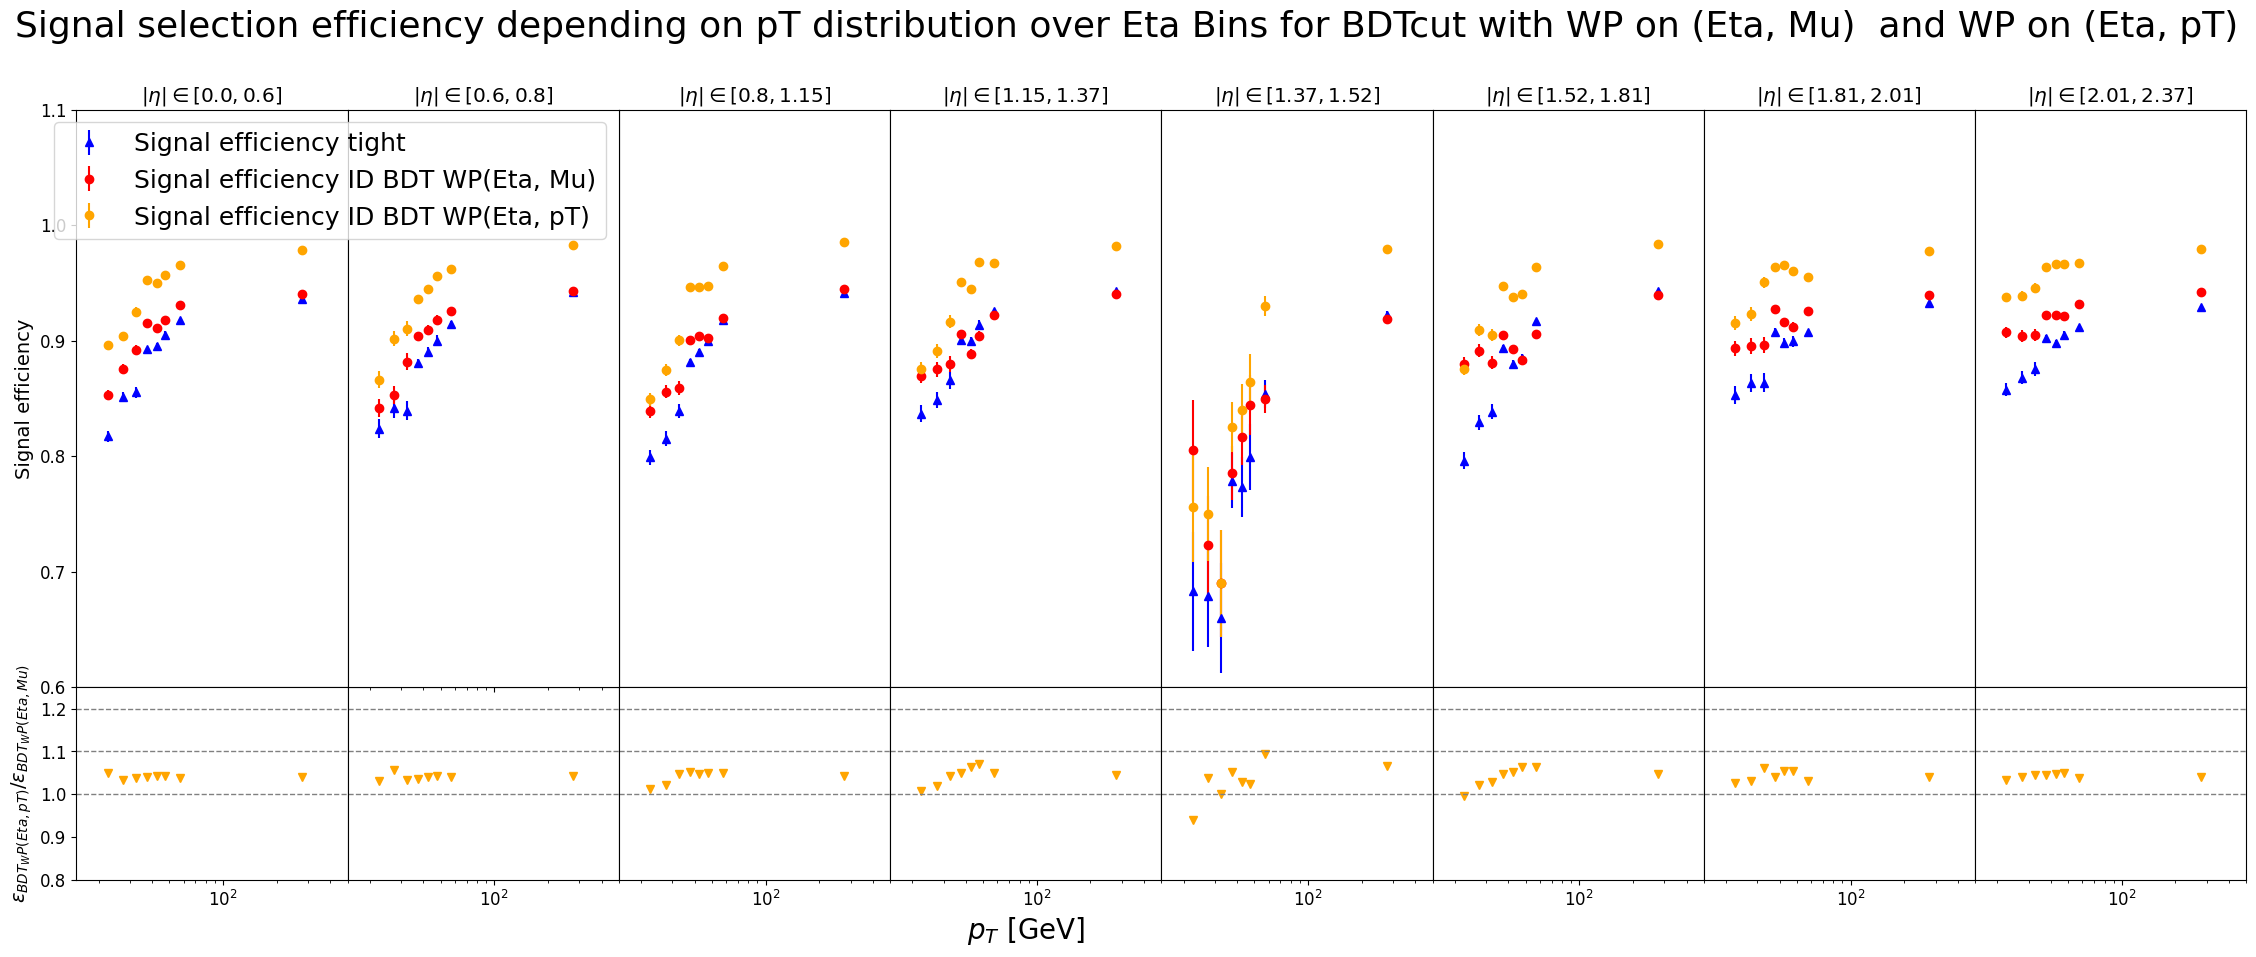

In [56]:
plt.rcParams.update({'font.size': 12})

fig, (ax, rax) = plt.subplots(nrows=2, ncols=8, figsize=(28,10), 
                              gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(pt_sig, eff_sig_tight_EtapT[i], efferr_sig_tight_EtapT[i],
        fmt="^", label='Signal efficiency tight', color = 'blue')
    ax[i].errorbar(pt_sig, eff_sig_bdt_EtapT_WPEtaMu[i], efferr_sig_bdt_EtapT_WPEtaMu[i],
        fmt="o", label='Signal efficiency ID BDT WP(Eta, Mu)', color = 'red')  
    ax[i].errorbar(pt_sig, eff_sig_bdt_EtapT_WPEtapT[i], efferr_sig_bdt_EtapT_WPEtapT[i],
        fmt="o", label='Signal efficiency ID BDT WP(Eta, pT)', color = 'orange')    
    ax[i].set_xscale('log')
    if (i!=0):
        ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    rax[i].plot(pt_sig, eff_sig_bdt_EtapT_WPEtapT[i]/eff_sig_bdt_EtapT_WPEtaMu[i], 'v', color = 'orange')
    rax[i].axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=1.2, color='grey', linestyle='--', linewidth=1)
    rax[i].set_xlim([15, 5*10**2])
    rax[i].set_ylim([0.8, 1.25])
    ax[i].set_ylim([0.6, 1.1])
    if (i!=0):
        rax[i].set_yticks([])
        
rax[0].set_ylabel(r'$\epsilon_{BDT_WP(Eta, pT)}$/$\epsilon_{BDT_WP(Eta, Mu)}$', fontsize=14)
ax[0].set_ylabel("Signal efficiency",  fontsize=14)
rax[3].set_xlabel("$p_{T}$ [GeV]",  fontsize=20)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 18)

fig.suptitle('Signal selection efficiency depending on pT distribution over Eta Bins for BDTcut with WP on (Eta, Mu)  and WP on (Eta, pT)', fontsize=26)

#plt.savefig(savedir+"BDTcut for WP on (Eta, Mu)  and WP on (Eta, pT) Signal selection efficiency.pdf")
plt.show()

In [57]:
df_sig = df.query('truth_label == 1')
df_bkg = df.query('truth_label == 0')
#df_sig.head(5)

In [58]:
# num and efficiency for the BDT WP (Eta, pT)
df_sig_bdt_EtaMu_WPEtapT = df_sig.query('pass_BDTcut_samebkgeff_tight_WPEtapT')
num_sig_bdt_EtaMu_WPEtapT = hist.Hist(axis_eta, axis_mu).fill(df_sig_bdt_EtaMu_WPEtapT["y_abs_eta"], df_sig_bdt_EtaMu_WPEtapT["evt_mu"])

df_bkg_bdt_EtaMu_WPEtapT = df_bkg.query('pass_BDTcut_samebkgeff_tight_WPEtapT')
num_bkg_bdt_EtaMu_WPEtapT = hist.Hist(axis_eta, axis_mu).fill(df_bkg_bdt_EtaMu_WPEtapT["y_abs_eta"], df_bkg_bdt_EtaMu_WPEtapT["evt_mu"])

In [59]:
eff_sig_bdt_EtaMu_WPEtapT, efferr_sig_bdt_EtaMu_WPEtapT = efficiency(num_sig_bdt_EtaMu_WPEtapT, den_sig_EtaMu)
eff_bkg_bdt_EtaMu_WPEtapT, efferr_bkg_bdt_EtaMu_WPEtapT = efficiency(num_bkg_bdt_EtaMu_WPEtapT, den_bkg_EtaMu)

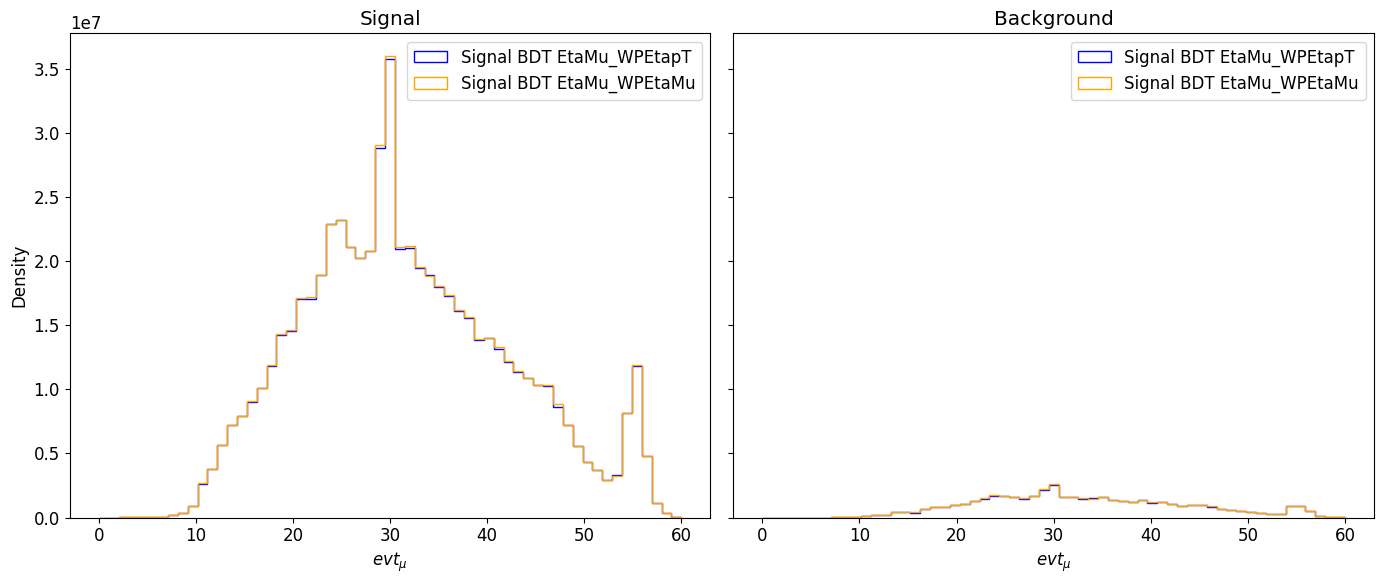

In [60]:
# evt-mu
edges_mu1 = np.linspace(0, 60, 60)

den_mu_sig, _ = np.histogram(df_sig["evt_mu"], bins=edges_mu1, weights=df_sig["weight"])
den_mu_bkg, _ = np.histogram(df_bkg["evt_mu"], bins=edges_mu1, weights=df_bkg["weight"])

num_mu_sig_tight, _ = np.histogram(df_sig_tight["evt_mu"], bins=edges_mu1, weights=df_sig_tight["weight"])
num_mu_bkg_tight, _ = np.histogram(df_bkg_tight["evt_mu"], bins=edges_mu1, weights=df_bkg_tight["weight"])


# Créer des sous-graphes pour le signal et le background
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot du signal
#axs[0].hist(df_sig["evt_mu"], bins=edges_mu1, weights=df_sig["weight"],  label='Signal', color='green', histtype='step')
#axs[0].hist(df_sig_tight["evt_mu"], bins=edges_mu1, weights=df_sig_tight["weight"],  label='Signal Tight', color='orange', histtype='step')
axs[0].hist(df_sig_bdt_EtaMu_WPEtapT["evt_mu"], bins=edges_mu1, weights=df_sig_bdt_EtaMu_WPEtapT["weight"], label='Signal BDT EtaMu_WPEtapT', color='blue', histtype='step')
axs[0].hist(df_sig_bdt_EtaMu_WPEtaMu["evt_mu"], bins=edges_mu1, weights=df_sig_bdt_EtaMu_WPEtaMu["weight"], label='Signal BDT EtaMu_WPEtaMu', color='orange', histtype='step')

axs[0].set_xlabel(r"$evt_\mu$")
axs[0].set_ylabel("Density")
axs[0].legend()
axs[0].set_title('Signal')

# Plot du background
#axs[1].hist(df_bkg["evt_mu"], bins=edges_mu1, weights=df_bkg["weight"],  label='Background', color='red', histtype='step')
#axs[1].hist(df_bkg_tight["evt_mu"], bins=edges_mu1, weights=df_bkg_tight["weight"], label='Background Tight', color='cyan', histtype='step')
axs[1].hist(df_bkg_bdt_EtaMu_WPEtapT["evt_mu"], bins=edges_mu1, weights=df_bkg_bdt_EtaMu_WPEtapT["weight"], label='Signal BDT EtaMu_WPEtapT', color='blue', histtype='step')
axs[1].hist(df_bkg_bdt_EtaMu_WPEtaMu["evt_mu"], bins=edges_mu1, weights=df_bkg_bdt_EtaMu_WPEtaMu["weight"], label='Signal BDT EtaMu_WPEtaMu', color='orange', histtype='step')

axs[1].set_xlabel(r"$evt_\mu$")
axs[1].legend()
axs[1].set_title('Background')

plt.tight_layout()

# Sauvegarder le graphique si besoin
# plt.savefig("/home/chardong/y_identification/Venv/save_plots/variables_distrib_simple_plots/bkg+sig_MU_distribution_sample_hard_scattering")

# Afficher le graphique
plt.show()


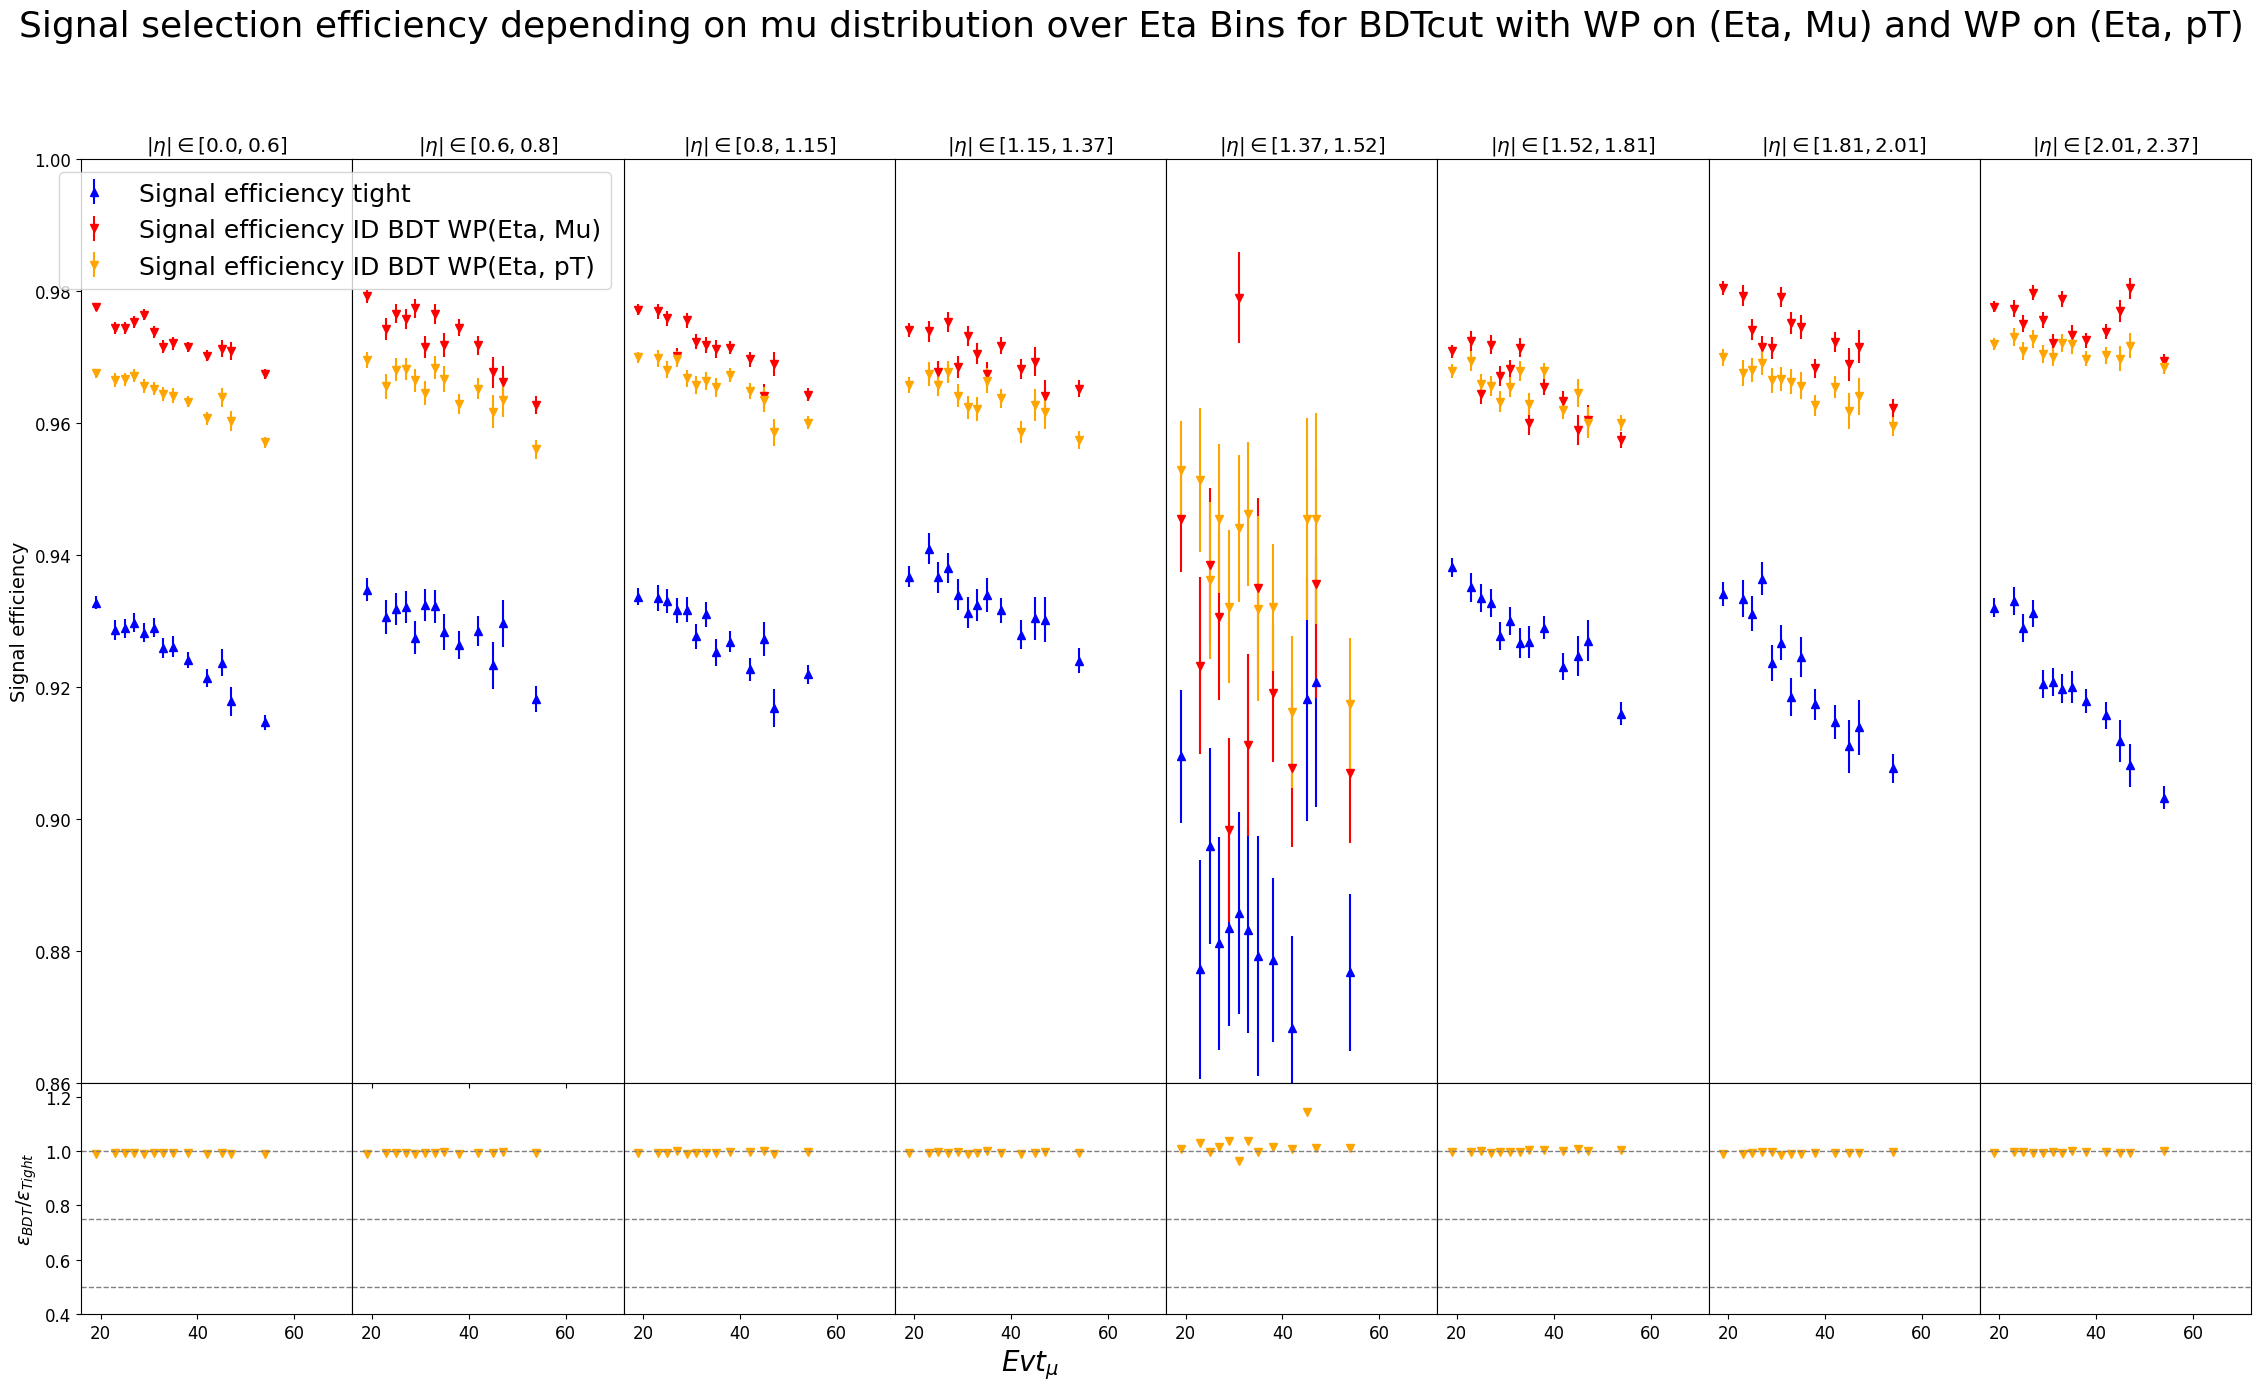

In [61]:
plt.rcParams.update({'font.size': 12})

fig, (ax, rax) = plt.subplots(nrows=2, ncols=8, figsize=(28,15), 
                              gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(mu, eff_sig_tight_EtaMu[i], efferr_sig_tight_EtaMu[i],
        fmt="^", label='Signal efficiency tight', color = 'blue')
    ax[i].errorbar(mu, eff_sig_bdt_EtaMu_WPEtaMu[i], efferr_sig_bdt_EtaMu_WPEtaMu[i],
        fmt="v", label='Signal efficiency ID BDT WP(Eta, Mu)', color = 'red')  
    ax[i].errorbar(mu, eff_sig_bdt_EtaMu_WPEtapT[i], efferr_sig_bdt_EtaMu_WPEtapT[i],
        fmt="v", label='Signal efficiency ID BDT WP(Eta, pT)', color = 'orange')   
#    ax[i].set_xscale('log')
    if (i!=0):
        ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    rax[i].plot(mu, eff_sig_bdt_EtaMu_WPEtapT[i]/eff_sig_bdt_EtaMu_WPEtaMu[i], 'v', color = 'orange')
    rax[i].axhline(y=0.5, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=0.75, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=1., color='grey', linestyle='--', linewidth=1)
    rax[i].set_xlim([16, 72])
    rax[i].set_ylim([0.4, 1.25])
    ax[i].set_ylim([0.86, 1.0])
    if (i!=0):
        rax[i].set_yticks([])
        
rax[0].set_ylabel(r'$\epsilon_{BDT}$/$\epsilon_{Tight}$', fontsize=14)
ax[0].set_ylabel("Signal efficiency",  fontsize=14)
rax[3].set_xlabel("$Evt_{\mu}$",  fontsize=20)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 18)

fig.suptitle('Signal selection efficiency depending on mu distribution over Eta Bins for BDTcut with WP on (Eta, Mu) and WP on (Eta, pT)', fontsize=26)

plt.savefig(savedir+"Signal selection efficiency depending on mu distribution over Eta Bins for BDTcut with WP on (Eta, Mu) and WP on (Eta, pT).pdf")
plt.show()

## Pour vérifier

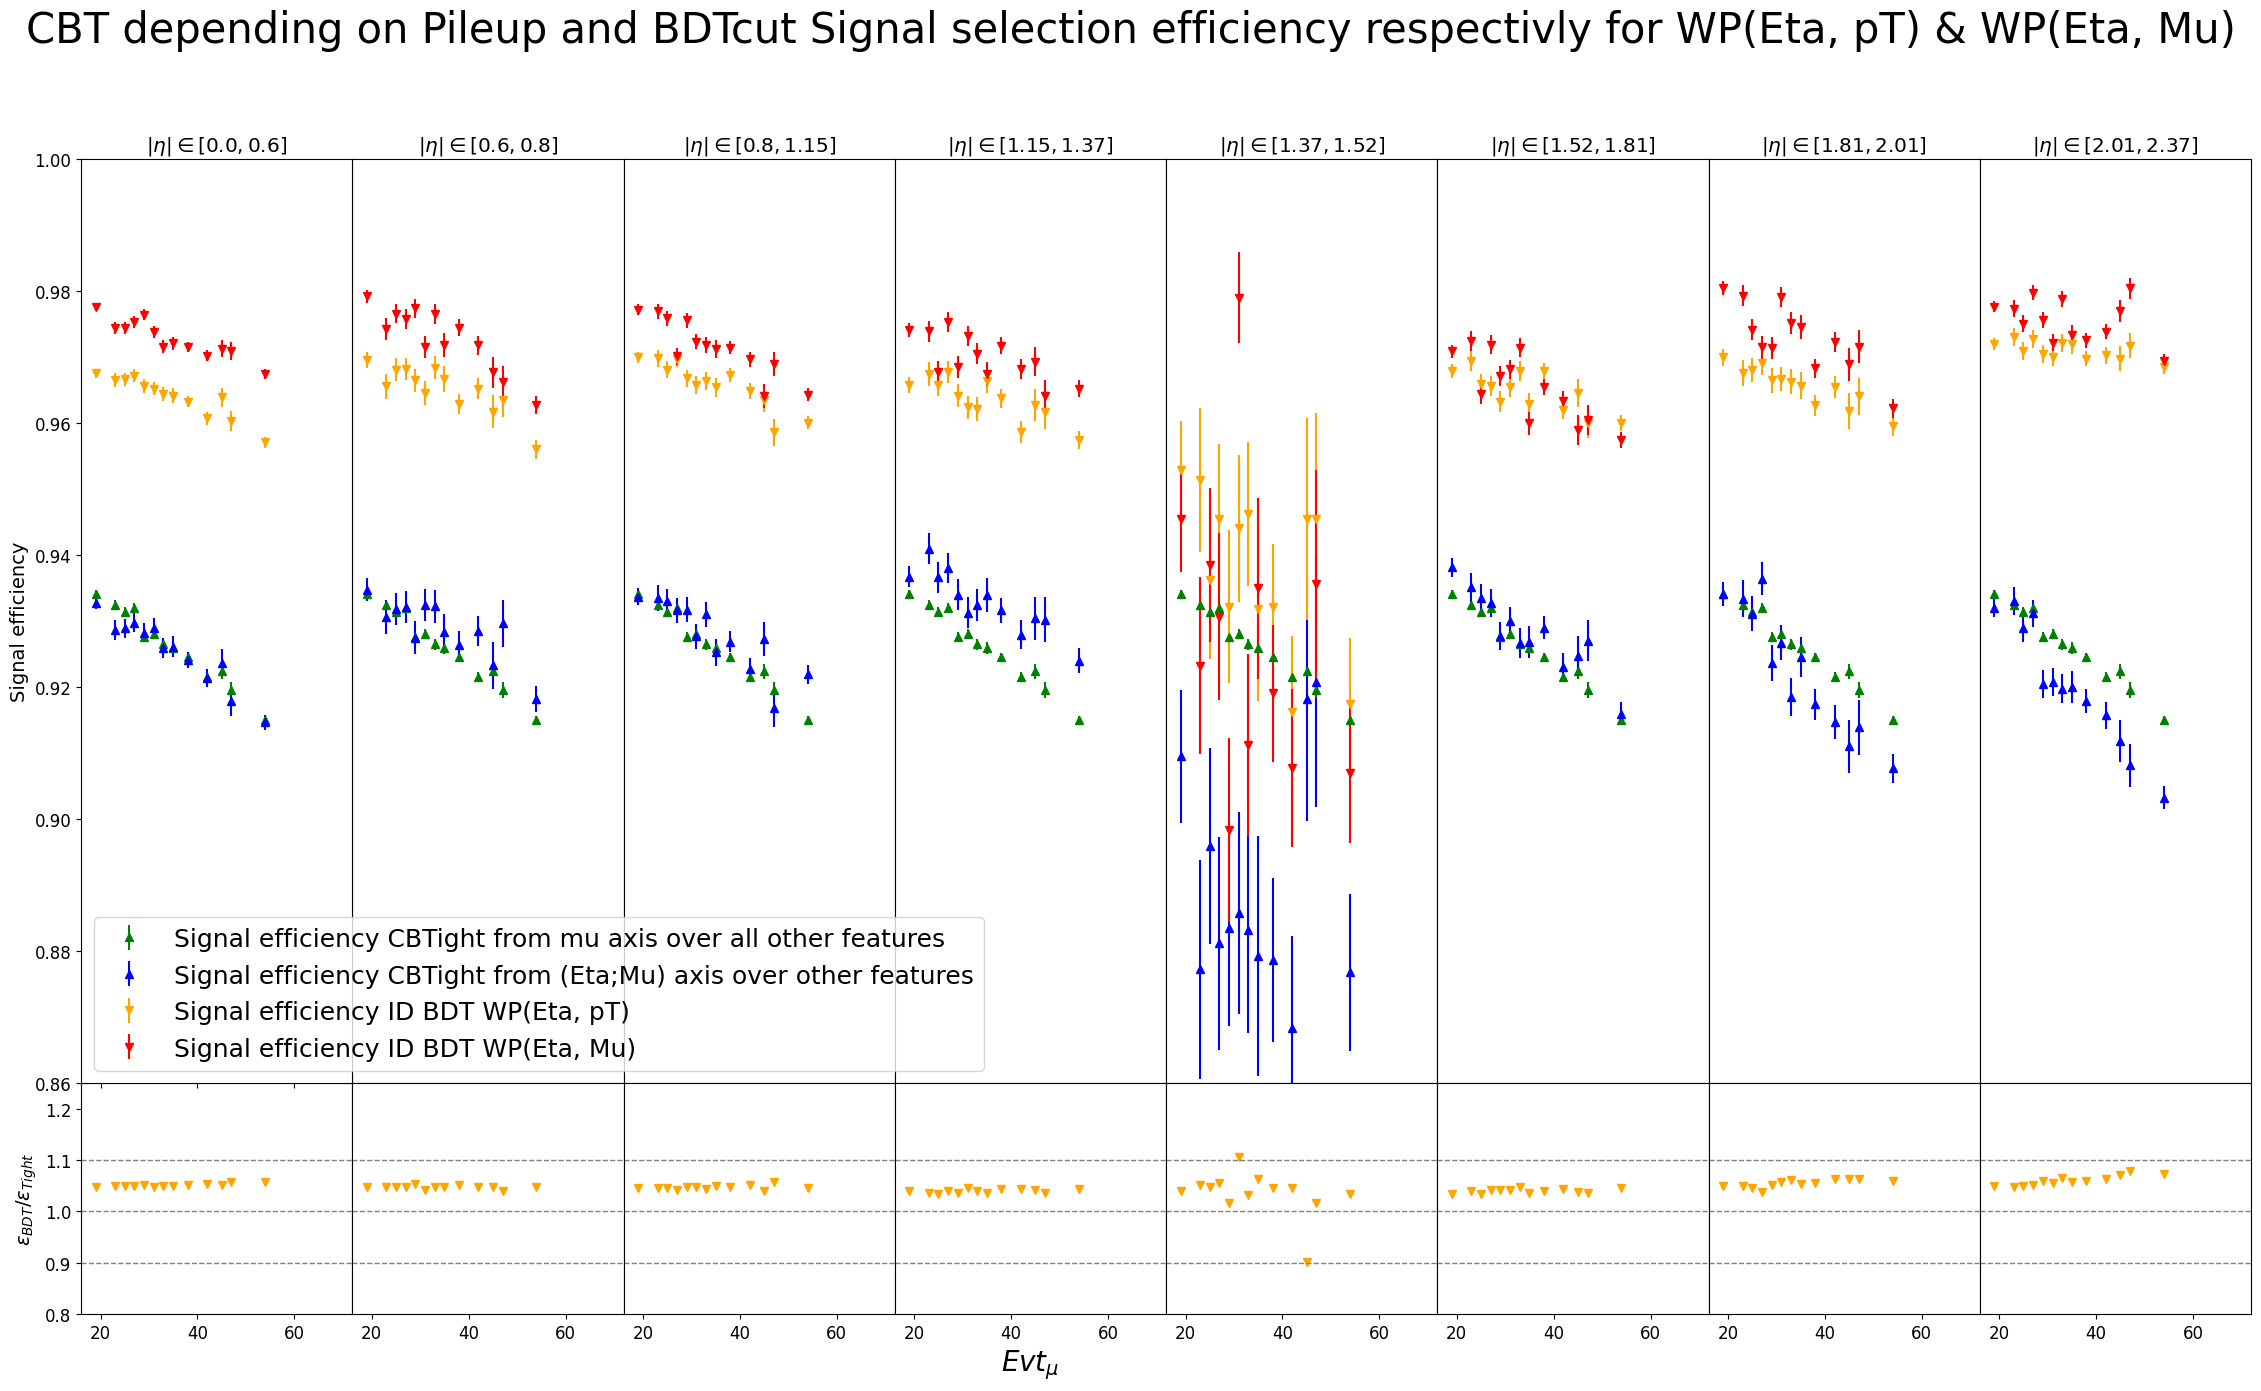

In [62]:
plt.rcParams.update({'font.size': 12})

fig, (ax, rax) = plt.subplots(nrows=2, ncols=8, figsize=(28,15), 
                              gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(mu, eff_sig_tight_mu, efferr_sig_tight_mu,
        fmt="^", label='Signal efficiency CBTight from mu axis over all other features', color = 'green')
    
    ax[i].errorbar(mu, eff_sig_tight_EtaMu[i], efferr_sig_tight_EtaMu[i],
        fmt="^", label='Signal efficiency CBTight from (Eta;Mu) axis over other features', color = 'blue')
    
    ax[i].errorbar(mu, eff_sig_bdt_EtaMu_WPEtapT[i], efferr_sig_bdt_EtaMu_WPEtapT[i],
        fmt="v", label='Signal efficiency ID BDT WP(Eta, pT)', color = 'orange')    
    
    ax[i].errorbar(mu, eff_sig_bdt_EtaMu_WPEtaMu[i], efferr_sig_bdt_EtaMu_WPEtaMu[i],
        fmt="v", label='Signal efficiency ID BDT WP(Eta, Mu)', color = 'red') 
    
    #ax[i].set_xscale('log')
    if (i!=0):
        ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    rax[i].plot(mu, eff_sig_bdt_EtaMu_WPEtaMu[i]/eff_sig_tight_EtaMu[i], 'v', color = 'orange')
    rax[i].axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=0.9, color='grey', linestyle='--', linewidth=1)
    rax[i].set_xlim([16, 72])
    rax[i].set_ylim([0.8, 1.25])
    ax[i].set_ylim([0.86, 1.0])
    if (i!=0):
        rax[i].set_yticks([])
        
rax[0].set_ylabel(r'$\epsilon_{BDT}$/$\epsilon_{Tight}$', fontsize=14)
ax[0].set_ylabel("Signal efficiency",  fontsize=14)
rax[3].set_xlabel("$Evt_{\mu}$",  fontsize=20)
ax[0].set_zorder(ax[1].get_zorder() + 1)
ax[0].legend(fontsize = 18)

fig.suptitle('CBT depending on Pileup and BDTcut Signal selection efficiency respectivly for WP(Eta, pT) & WP(Eta, Mu)', fontsize=30)

#plt.savefig(savedir+"BDT_PID_reject_effi/CBT depending on Pileup and BDTcut Signal selection efficiency respectivly for WP(Eta, pT) & WP(Eta, Mu).pdf")
plt.show()

In [63]:
# num and efficiency for the BDT WP (Eta, pT)

df_sig_bdt_Mu_WPEtapT = df_sig.query('pass_BDTcut_samebkgeff_tight_WPEtapT')
num_sig_bdt_Mu_WPEtapT = hist.Hist(axis_mu).fill(df_sig_bdt_Mu_WPEtapT["evt_mu"])

df_bkg_bdt_Mu_WPEtapT = df_bkg.query('pass_BDTcut_samebkgeff_tight_WPEtapT')
num_bkg_bdt_Mu_WPEtapT = hist.Hist(axis_mu).fill(df_bkg_bdt_Mu_WPEtapT["evt_mu"])

In [64]:
eff_sig_bdt_Mu_WPEtapT, efferr_sig_bdt_Mu_WPEtapT = efficiency(num_sig_bdt_Mu_WPEtapT, den_sig_mu)
eff_bkg_bdt_Mu_WPEtapT, efferr_bkg_bdt_Mu_WPEtapT = efficiency(num_bkg_bdt_Mu_WPEtapT, den_bkg_mu)

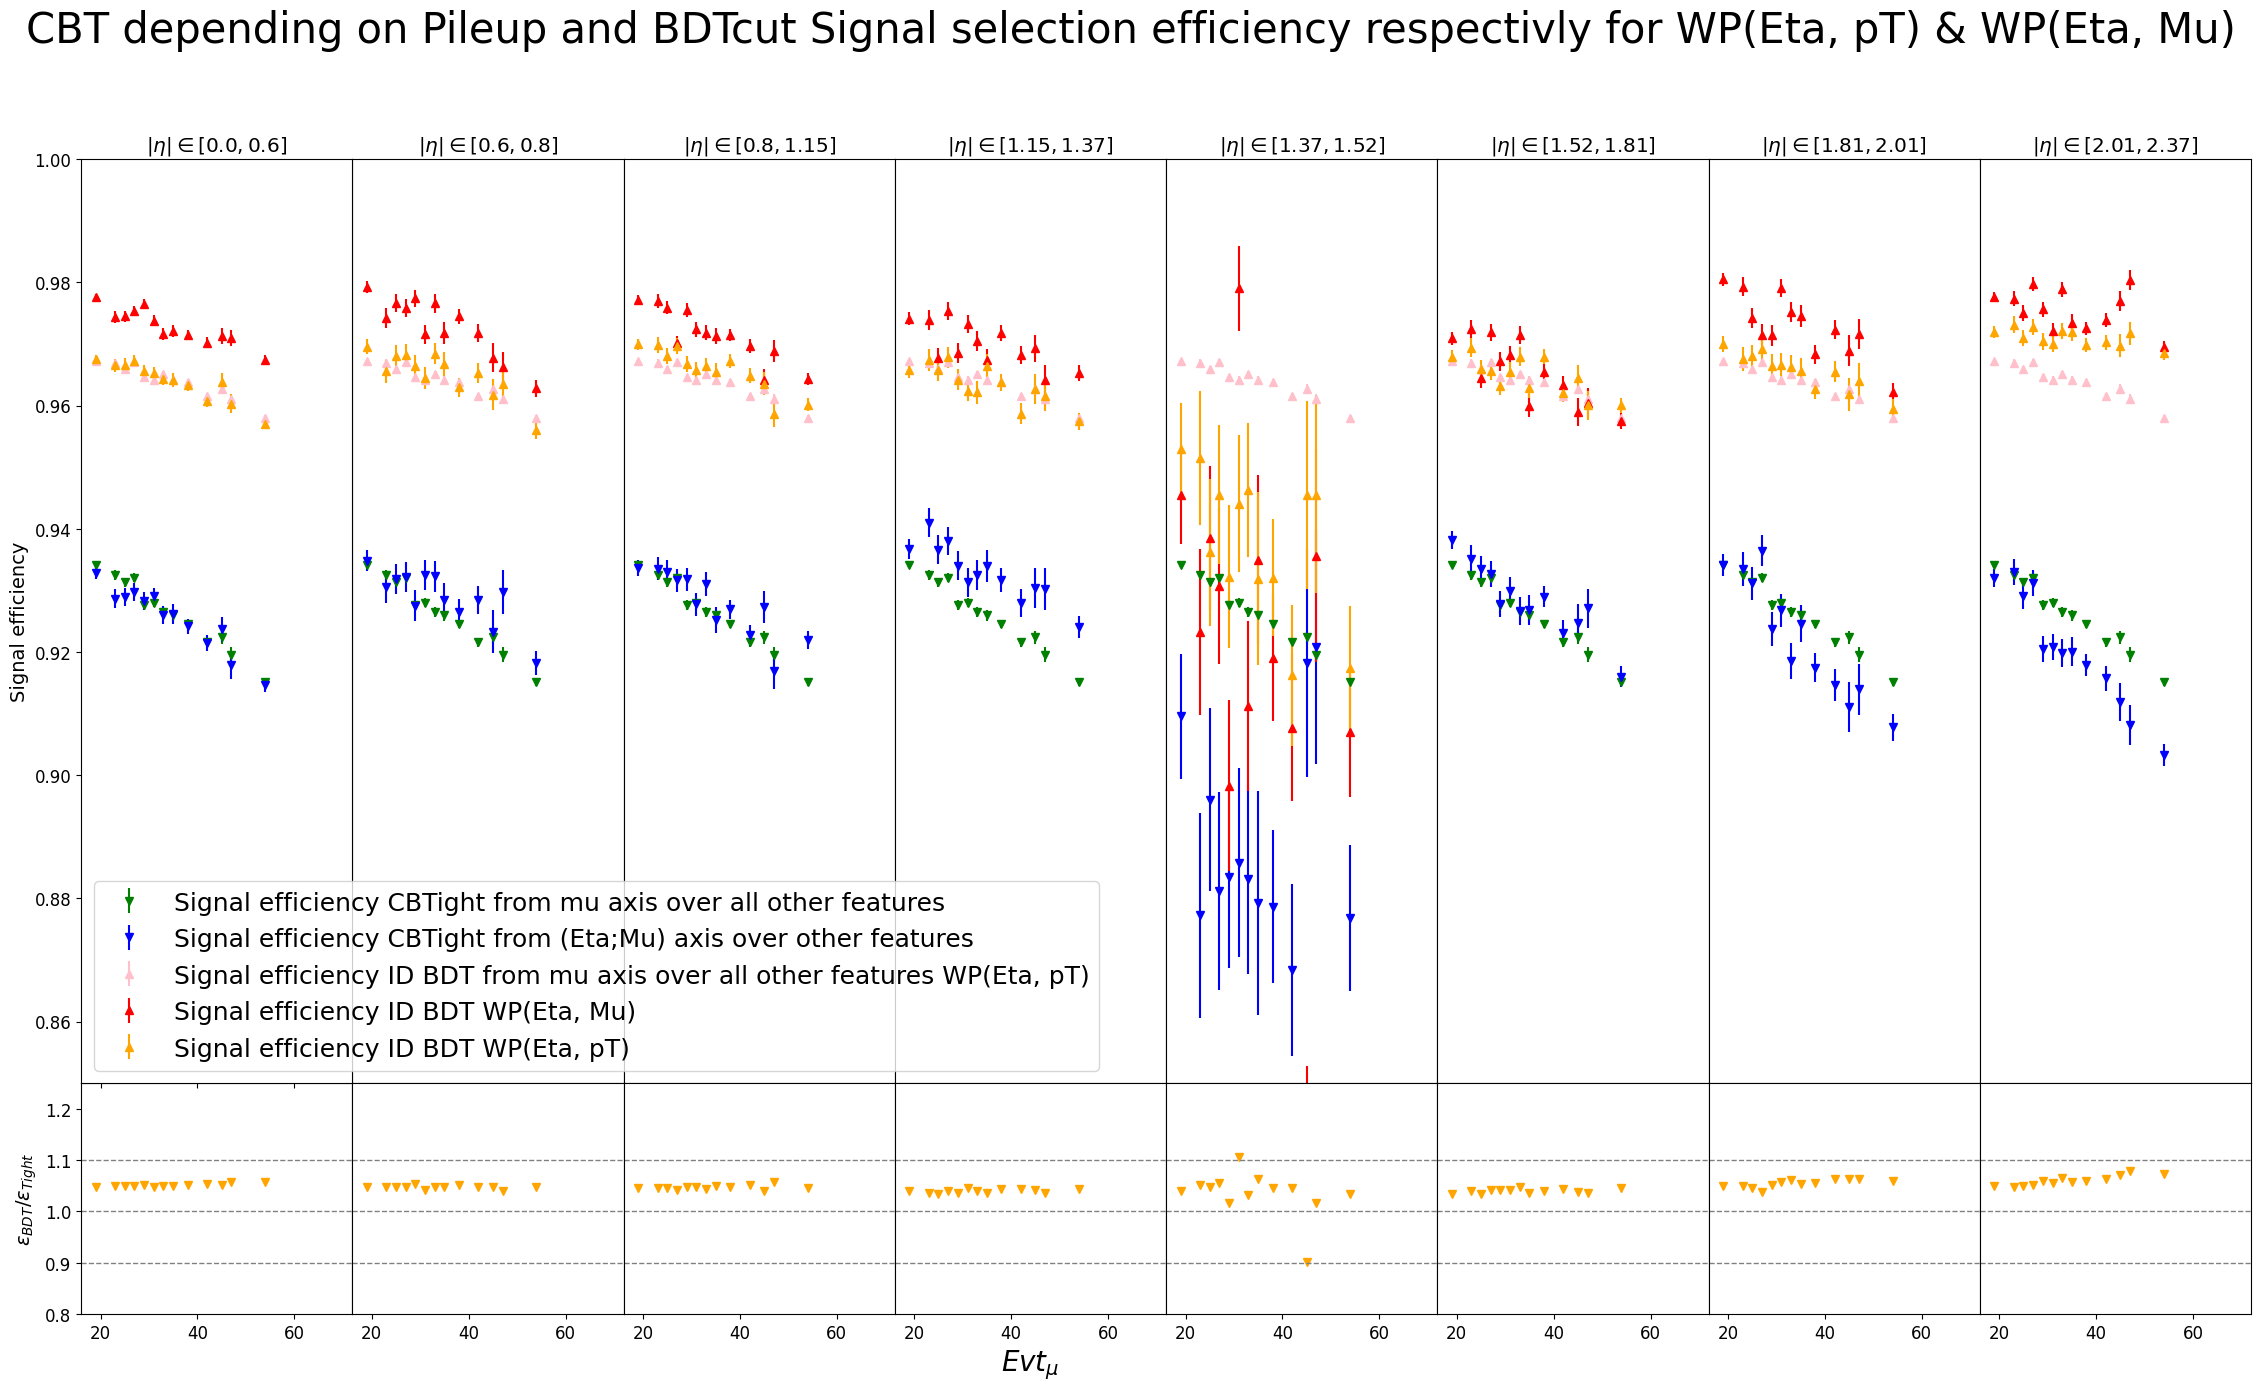

In [65]:
plt.rcParams.update({'font.size': 12})

fig, (ax, rax) = plt.subplots(nrows=2, ncols=8, figsize=(28,15), 
                              gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(mu, eff_sig_tight_mu, efferr_sig_tight_mu,
        fmt="v", label='Signal efficiency CBTight from mu axis over all other features', color = 'green')
    
    ax[i].errorbar(mu, eff_sig_tight_EtaMu[i], efferr_sig_tight_EtaMu[i],
        fmt="v", label='Signal efficiency CBTight from (Eta;Mu) axis over other features', color = 'blue')
    
    ax[i].errorbar(mu, eff_sig_bdt_Mu_WPEtapT, efferr_sig_bdt_Mu_WPEtapT,
        fmt="^", label='Signal efficiency ID BDT from mu axis over all other features WP(Eta, pT)', color = 'pink')    
    
    ax[i].errorbar(mu, eff_sig_bdt_EtaMu_WPEtaMu[i], efferr_sig_bdt_EtaMu_WPEtaMu[i],
        fmt="^", label='Signal efficiency ID BDT WP(Eta, Mu)', color = 'red') 
    
    ax[i].errorbar(mu, eff_sig_bdt_EtaMu_WPEtapT[i], efferr_sig_bdt_EtaMu_WPEtapT[i],
        fmt="^", label='Signal efficiency ID BDT WP(Eta, pT)', color = 'orange') 
    
    #ax[i].set_xscale('log')
    if (i!=0):
        ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    rax[i].plot(mu, eff_sig_bdt_EtaMu_WPEtaMu[i]/eff_sig_tight_EtaMu[i], 'v', color = 'orange')
    rax[i].axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=0.9, color='grey', linestyle='--', linewidth=1)
    rax[i].set_xlim([16, 72])
    rax[i].set_ylim([0.8, 1.25])
    ax[i].set_ylim([0.85, 1.0])
    if (i!=0):
        rax[i].set_yticks([])
        
rax[0].set_ylabel(r'$\epsilon_{BDT}$/$\epsilon_{Tight}$', fontsize=14)
ax[0].set_ylabel("Signal efficiency",  fontsize=14)
rax[3].set_xlabel("$Evt_{\mu}$",  fontsize=20)
ax[0].set_zorder(ax[1].get_zorder() + 1)
ax[0].legend(fontsize = 18)

fig.suptitle('CBT depending on Pileup and BDTcut Signal selection efficiency respectivly for WP(Eta, pT) & WP(Eta, Mu)', fontsize=30)

plt.savefig(savedir+"CBT depending on Pileup and BDTcut Signal selection efficiency respectivly for WP(Eta, pT) & WP(Eta, Mu).pdf")
plt.show()

# WP paramétré on Eta, pT et Mu:

In [66]:
df_bkg_indexed_WPEtapTmu = df_bkg.set_index(['mu_bin_bkg', 'pt_bin_bkg', 'eta_bin_bkg']).sort_index()
#df_bkg_indexed_WPEtapTmu

In [67]:
bdt_cut_same_background_efficiency_tight_WPEtapTmu = {} # store optimal BDT thresholds

for (ieta, ipt, imu), eff_tight in np.ndenumerate(eff_bkg_tight_EtapTmu): 
    # select subsample of events corresponding to the current (eta,mu) bin
    
    df_bin = df_bkg_indexed_WPEtapTmu.loc[imu, ipt, ieta] # using indexed df to speedup selection
    
    # find and store optimal BDT selection for current bin
    cut_BDT = find_cut_with_root_scalar(df_bin, target_efficiency = eff_tight)
    bdt_cut_same_background_efficiency_tight_WPEtapTmu[imu, ipt, ieta] = cut_BDT

bdt_cut_same_background_efficiency_tight_WPEtapTmu = pd.Series(bdt_cut_same_background_efficiency_tight_WPEtapTmu).sort_index()
bdt_cut_same_background_efficiency_tight_WPEtapTmu.index.names = ['mu_bin_bkg', 'pt_bin_bkg', 'eta_bin_bkg']

#bdt_cut_same_background_efficiency_tight_WPEtapTmu

mu_bin_bkg  pt_bin_bkg  eta_bin_bkg
0           0           0              0.781734
                        1              0.772287
                        2              0.776044
                        3              0.660955
                        4              0.750000
                                         ...   
13          7           3              0.670966
                        4              0.467452
                        5              0.585730
                        6              0.798227
                        7              0.756970
Length: 896, dtype: float64

In [68]:
df = df.merge(bdt_cut_same_background_efficiency_tight_WPEtapTmu.rename('BDTcut_samebkgeff_tight'), 
             on=['mu_bin_bkg', 'pt_bin_bkg', 'eta_bin_bkg'], how="left")
df = df.assign(pass_BDTcut_samebkgeff_tight_WPEtapTmu = df['Original_signal_score'] > df['BDTcut_samebkgeff_tight'])

In [69]:
df.drop('BDTcut_samebkgeff_tight',axis=1,inplace=True)

In [70]:
df_sig = df.query('truth_label == 1')
df_bkg = df.query('truth_label == 0')

In [71]:
# num and efficiency for the BDT WP (Eta, pT)

df_sig_bdt_EtapTmu_WPEtapTmu = df_sig.query('pass_BDTcut_samebkgeff_tight_WPEtapTmu')
num_sig_bdt_EtapTmu_WPEtapTmu = hist.Hist(axis_eta, axis_pt_sig, axis_mu).fill(df_sig_bdt_EtapTmu_WPEtapTmu["y_abs_eta"], 
                                                    df_sig_bdt_EtapTmu_WPEtapTmu["y_pt"], df_sig_bdt_EtapTmu_WPEtapTmu["evt_mu"])

df_bkg_bdt_EtapTmu_WPEtapTmu = df_bkg.query('pass_BDTcut_samebkgeff_tight_WPEtapTmu')
num_bkg_bdt_EtapTmu_WPEtapTmu = hist.Hist(axis_eta, axis_pt_bkg, axis_mu).fill(df_bkg_bdt_EtapTmu_WPEtapTmu["y_abs_eta"], 
                                                    df_bkg_bdt_EtapTmu_WPEtapTmu["y_pt"], df_bkg_bdt_EtapTmu_WPEtapTmu["evt_mu"])

In [72]:
eff_sig_bdt_EtapTmu_WPEtapTmu, efferr_sig_bdt_EtapTmu_WPEtapTmu = efficiency(num_sig_bdt_EtapTmu_WPEtapTmu, den_sig_EtapTmu)
eff_bkg_bdt_EtapTmu_WPEtapTmu, efferr_bkg_bdt_EtapTmu_WPEtapTmu = efficiency(num_bkg_bdt_EtapTmu_WPEtapTmu, den_bkg_EtapTmu)

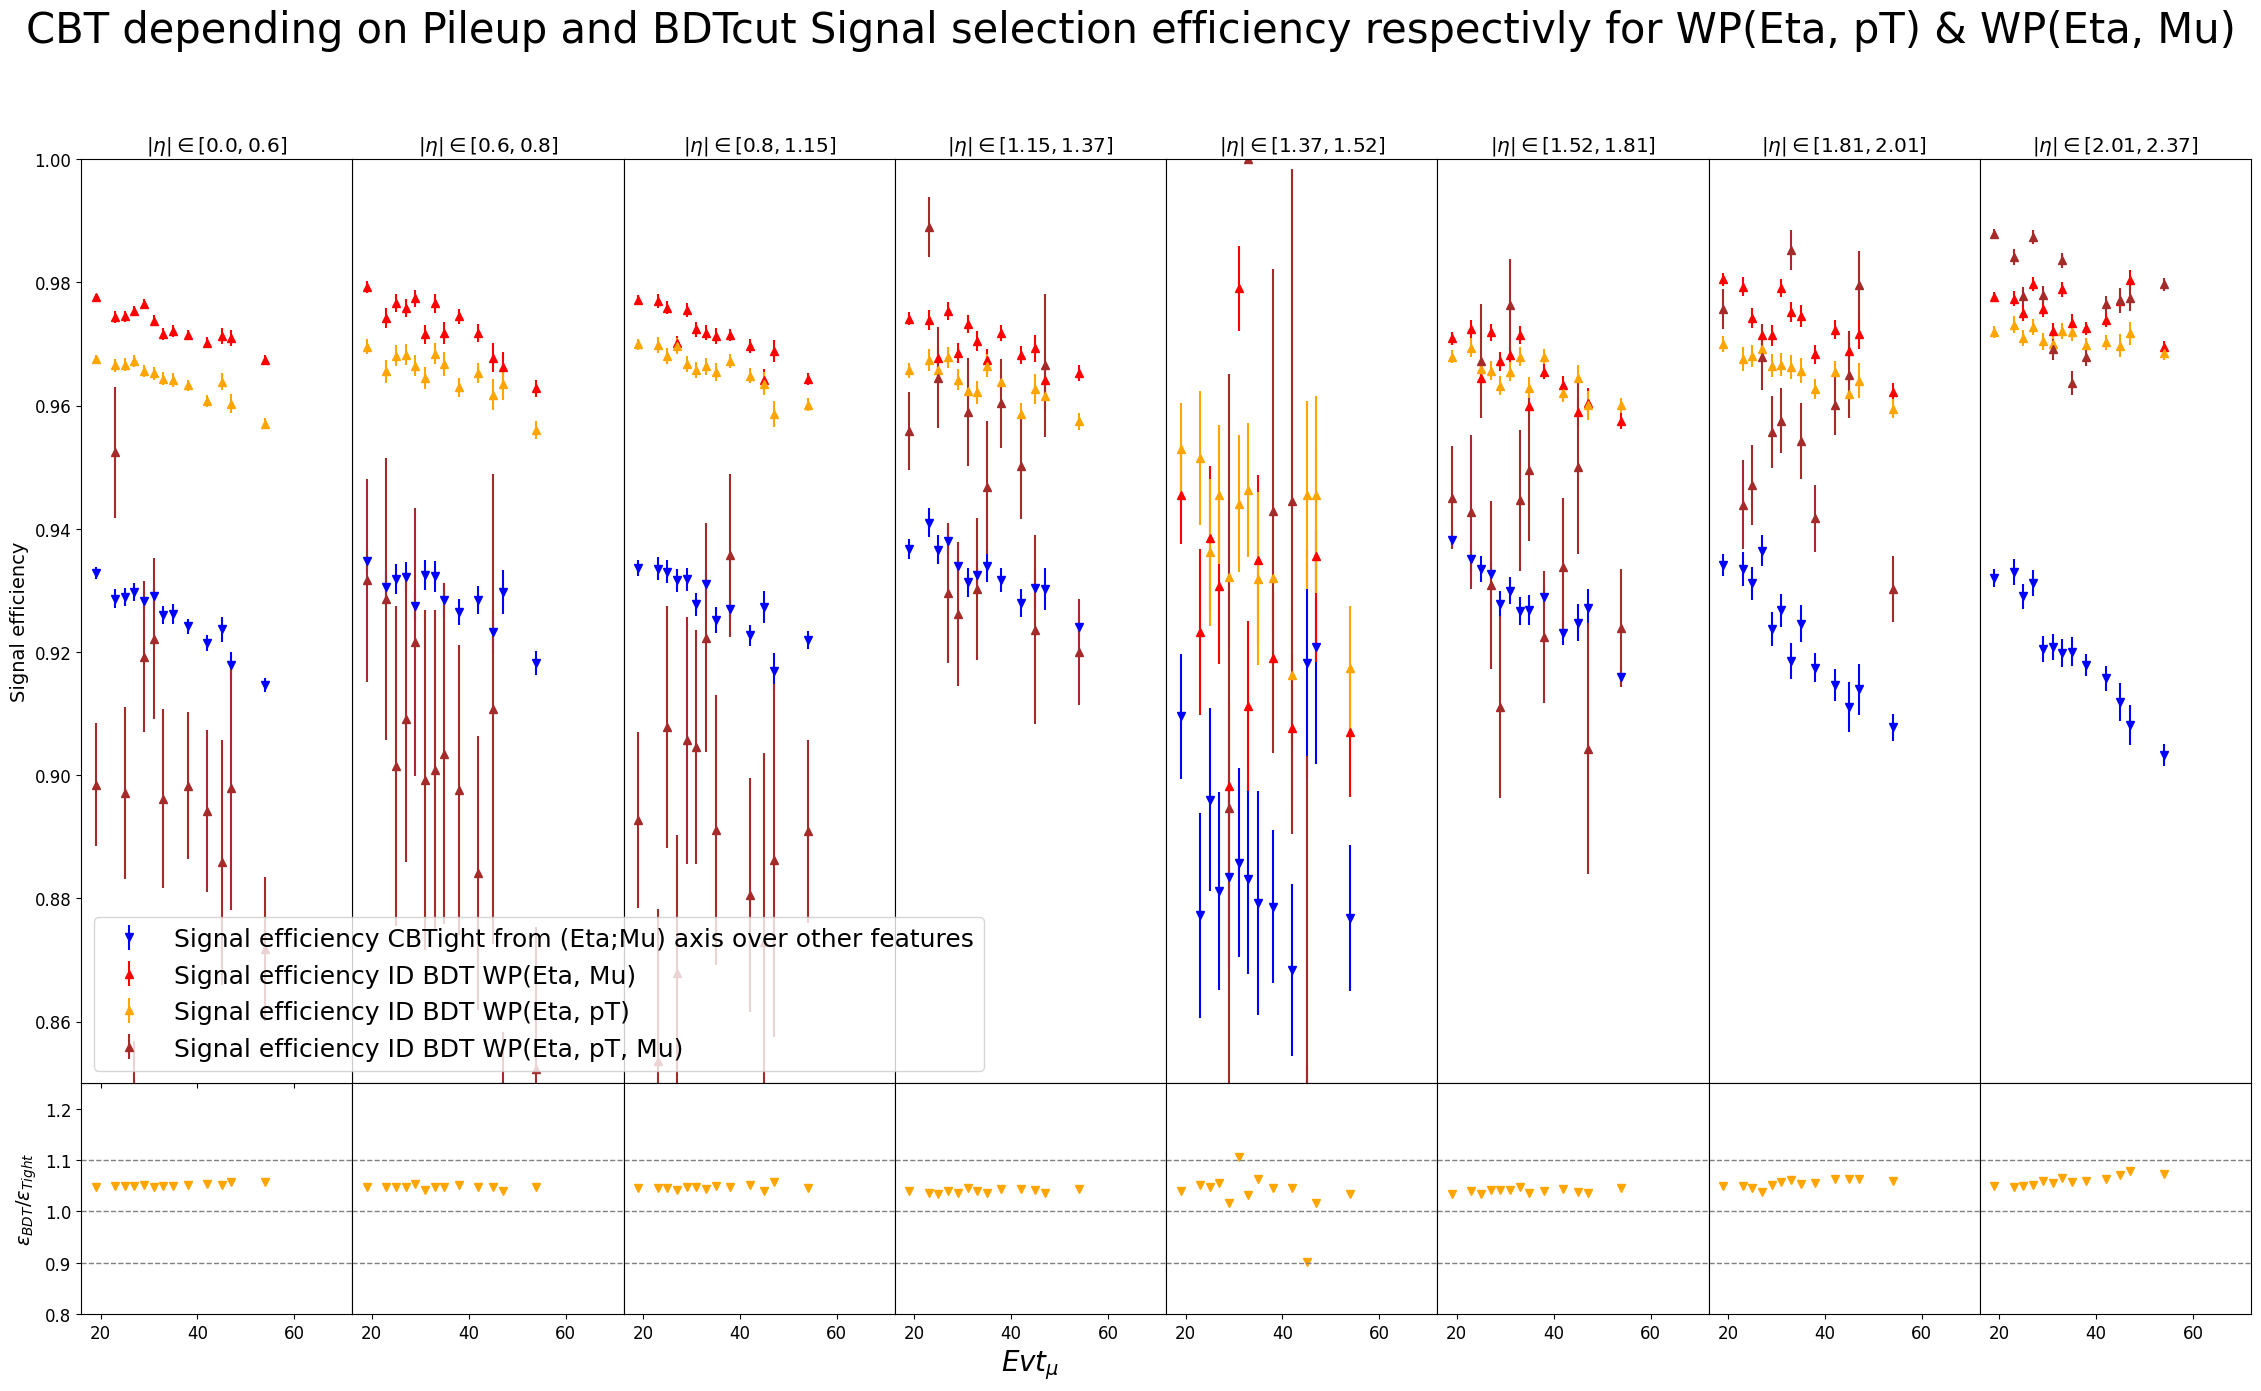

In [75]:
plt.rcParams.update({'font.size': 12})

fig, (ax, rax) = plt.subplots(nrows=2, ncols=8, figsize=(28,15), 
                              gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    
    ax[i].errorbar(mu, eff_sig_tight_EtaMu[i], efferr_sig_tight_EtaMu[i],
        fmt="v", label='Signal efficiency CBTight from (Eta;Mu) axis over other features', color = 'blue')  
    
    ax[i].errorbar(mu, eff_sig_bdt_EtaMu_WPEtaMu[i], efferr_sig_bdt_EtaMu_WPEtaMu[i],
        fmt="^", label='Signal efficiency ID BDT WP(Eta, Mu)', color = 'red') 
    
    ax[i].errorbar(mu, eff_sig_bdt_EtaMu_WPEtapT[i], efferr_sig_bdt_EtaMu_WPEtapT[i],
        fmt="^", label='Signal efficiency ID BDT WP(Eta, pT)', color = 'orange') 

    ax[i].errorbar(mu, eff_sig_bdt_EtapTmu_WPEtapTmu[i, i], efferr_sig_bdt_EtapTmu_WPEtapTmu[i, i],
        fmt="^", label='Signal efficiency ID BDT WP(Eta, pT, Mu)', color = 'brown') 
    
    #ax[i].set_xscale('log')
    if (i!=0):
        ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    rax[i].plot(mu, eff_sig_bdt_EtaMu_WPEtaMu[i]/eff_sig_tight_EtaMu[i], 'v', color = 'orange')
    rax[i].axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=0.9, color='grey', linestyle='--', linewidth=1)
    rax[i].set_xlim([16, 72])
    rax[i].set_ylim([0.8, 1.25])
    ax[i].set_ylim([0.85, 1.0])
    if (i!=0):
        rax[i].set_yticks([])
        
rax[0].set_ylabel(r'$\epsilon_{BDT}$/$\epsilon_{Tight}$', fontsize=14)
ax[0].set_ylabel("Signal efficiency",  fontsize=14)
rax[3].set_xlabel("$Evt_{\mu}$",  fontsize=20)
ax[0].set_zorder(ax[1].get_zorder() + 1)
ax[0].legend(fontsize = 18)

fig.suptitle('CBT depending on Pileup and BDTcut Signal selection efficiency respectivly for WP(Eta, pT) & WP(Eta, Mu)', fontsize=30)

#plt.savefig(savedir+"CBT depending on Pileup and BDTcut Signal selection efficiency respectivly for WP(Eta, pT) & WP(Eta, Mu).pdf")
plt.show()

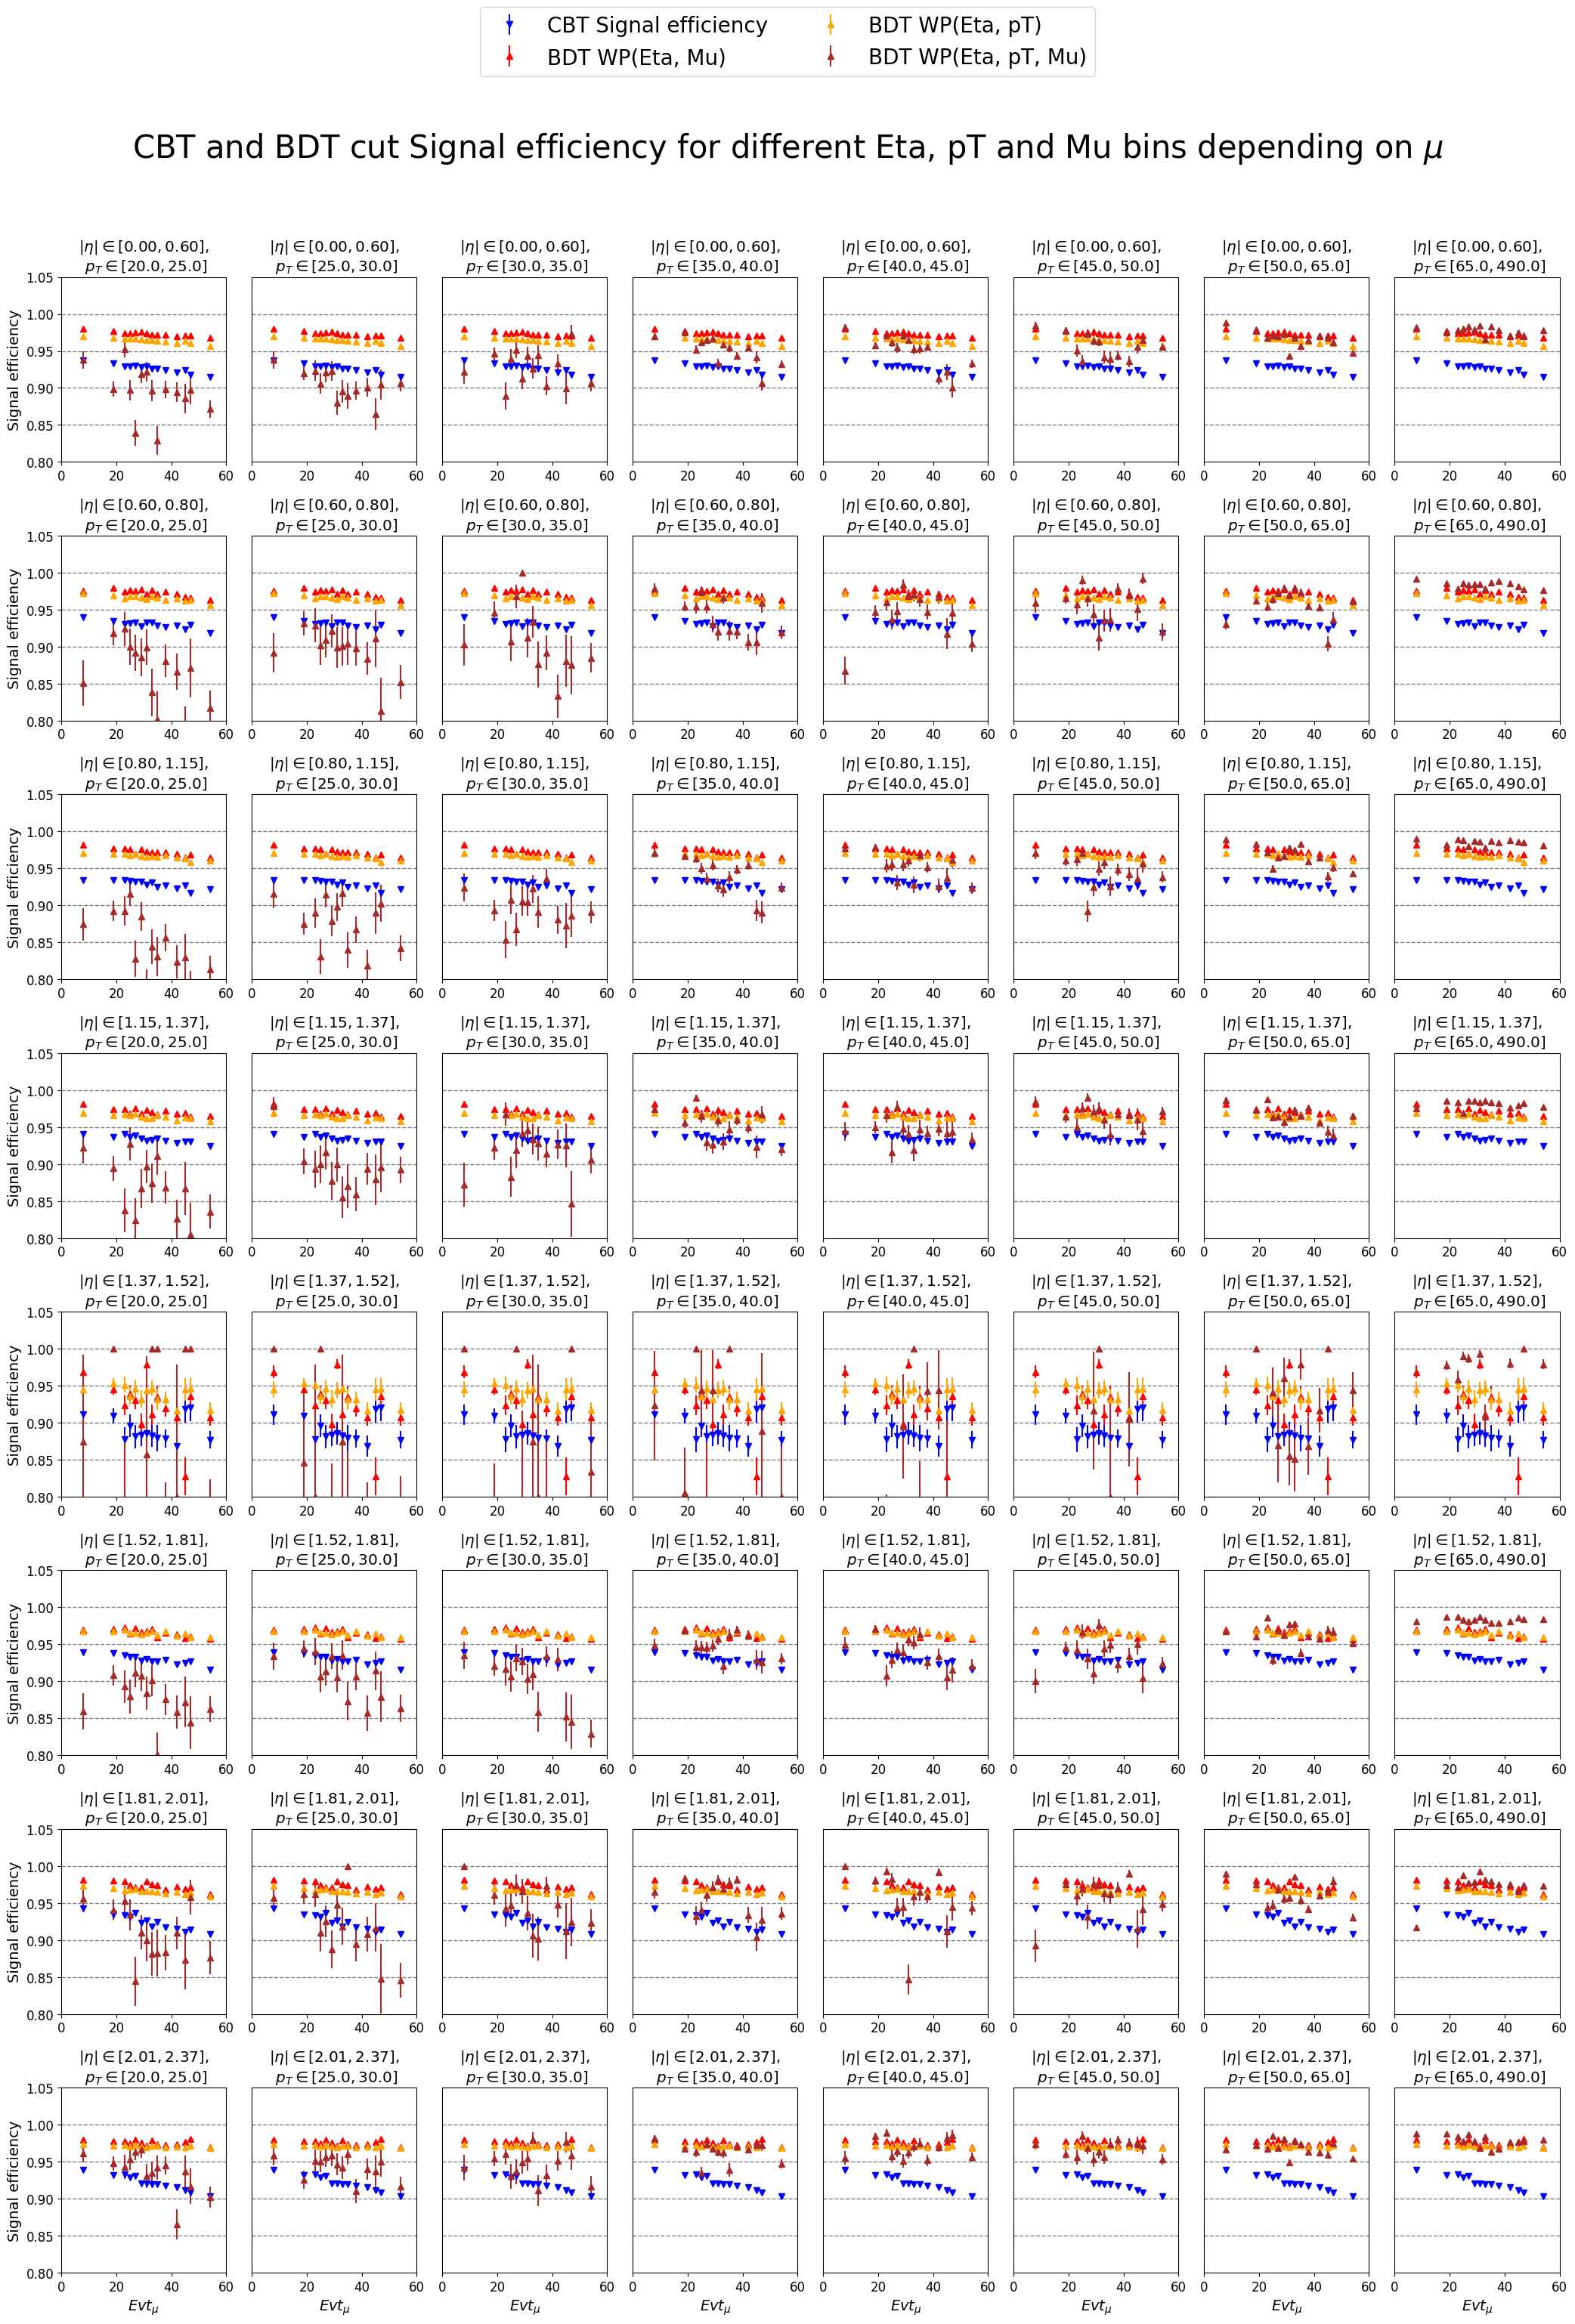

In [102]:
plt.rcParams.update({'font.size': 12})

num_eta_bins = len(edges_eta) - 1
num_pt_bins = len(edges_pt_sig) - 1

fig, axes = plt.subplots(nrows=num_eta_bins, ncols=num_pt_bins, figsize=(21, 29.7))
fig.subplots_adjust(wspace=0.3, hspace=0.4)

handles = []
labels = []

# Boucle sur les bins de eta et de pt
for i in range(num_eta_bins):
    for j in range(num_pt_bins):
        ax = axes[i, j]
        
        ax.axhline(y=0.85, color='grey', linestyle='--', linewidth=1)
        ax.axhline(y=0.9, color='grey', linestyle='--', linewidth=1)
        ax.axhline(y=0.95, color='grey', linestyle='--', linewidth=1)
        ax.axhline(y=1.0, color='grey', linestyle='--', linewidth=1)

        errorbar_tight_sig = ax.errorbar(mu, eff_sig_tight_EtaMu[i], efferr_sig_tight_EtaMu[i],
                                         fmt="v", label='CBT Signal efficiency', color='blue')

        errorbar_bdt_wp_eta_mu = ax.errorbar(mu, eff_sig_bdt_EtaMu_WPEtaMu[i], efferr_sig_bdt_EtaMu_WPEtaMu[i],
                                             fmt="^", label='BDT WP(Eta, Mu)', color='red')
        
        errorbar_bdt_wp_eta_pt = ax.errorbar(mu, eff_sig_bdt_EtaMu_WPEtapT[i], efferr_sig_bdt_EtaMu_WPEtapT[i],
                                             fmt="^", label='BDT WP(Eta, pT)', color='orange')

        errorbar_bdt_wp_eta_pt_mu = ax.errorbar(mu, eff_sig_bdt_EtapTmu_WPEtapTmu[i, j, :], efferr_sig_bdt_EtapTmu_WPEtapTmu[i, j, :],
                                                fmt="^", label='BDT WP(Eta, pT, Mu)', color='brown') 

        
        if i == 0 and j == 0:
            handles.extend([errorbar_tight_sig, errorbar_bdt_wp_eta_mu, errorbar_bdt_wp_eta_pt, errorbar_bdt_wp_eta_pt_mu])
            labels.extend(['CBT Signal efficiency', 'BDT WP(Eta, Mu)', 'BDT WP(Eta, pT)', 'BDT WP(Eta, pT, Mu)'])

        ax.set_title(f"$|\eta| \in [{edges_eta[i]:.2f}, {edges_eta[i+1]:.2f}]$,\n $p_T \in [{edges_pt_sig[j]:.1f}, {edges_pt_sig[j+1]:.1f}]$")
        ax.set_ylim(0.8, 1.05)
        ax.set_xlim(0.0, 60)
        
        if j != 0:
            ax.set_yticks([])

for i in range(num_eta_bins):
    axes[i, 0].set_ylabel("Signal efficiency", fontsize=14)

for j in range(num_pt_bins):
    axes[-1, j].set_xlabel("$Evt_{\mu}$", fontsize=14)

fig.suptitle('CBT and BDT cut Signal efficiency for different Eta, pT and Mu bins depending on $\mu$', fontsize=30)

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=2, fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(savedir + "CBT and BDT cut Signal efficiency for different Eta, pT and Mu bins depending on Pileup.pdf")
plt.show()


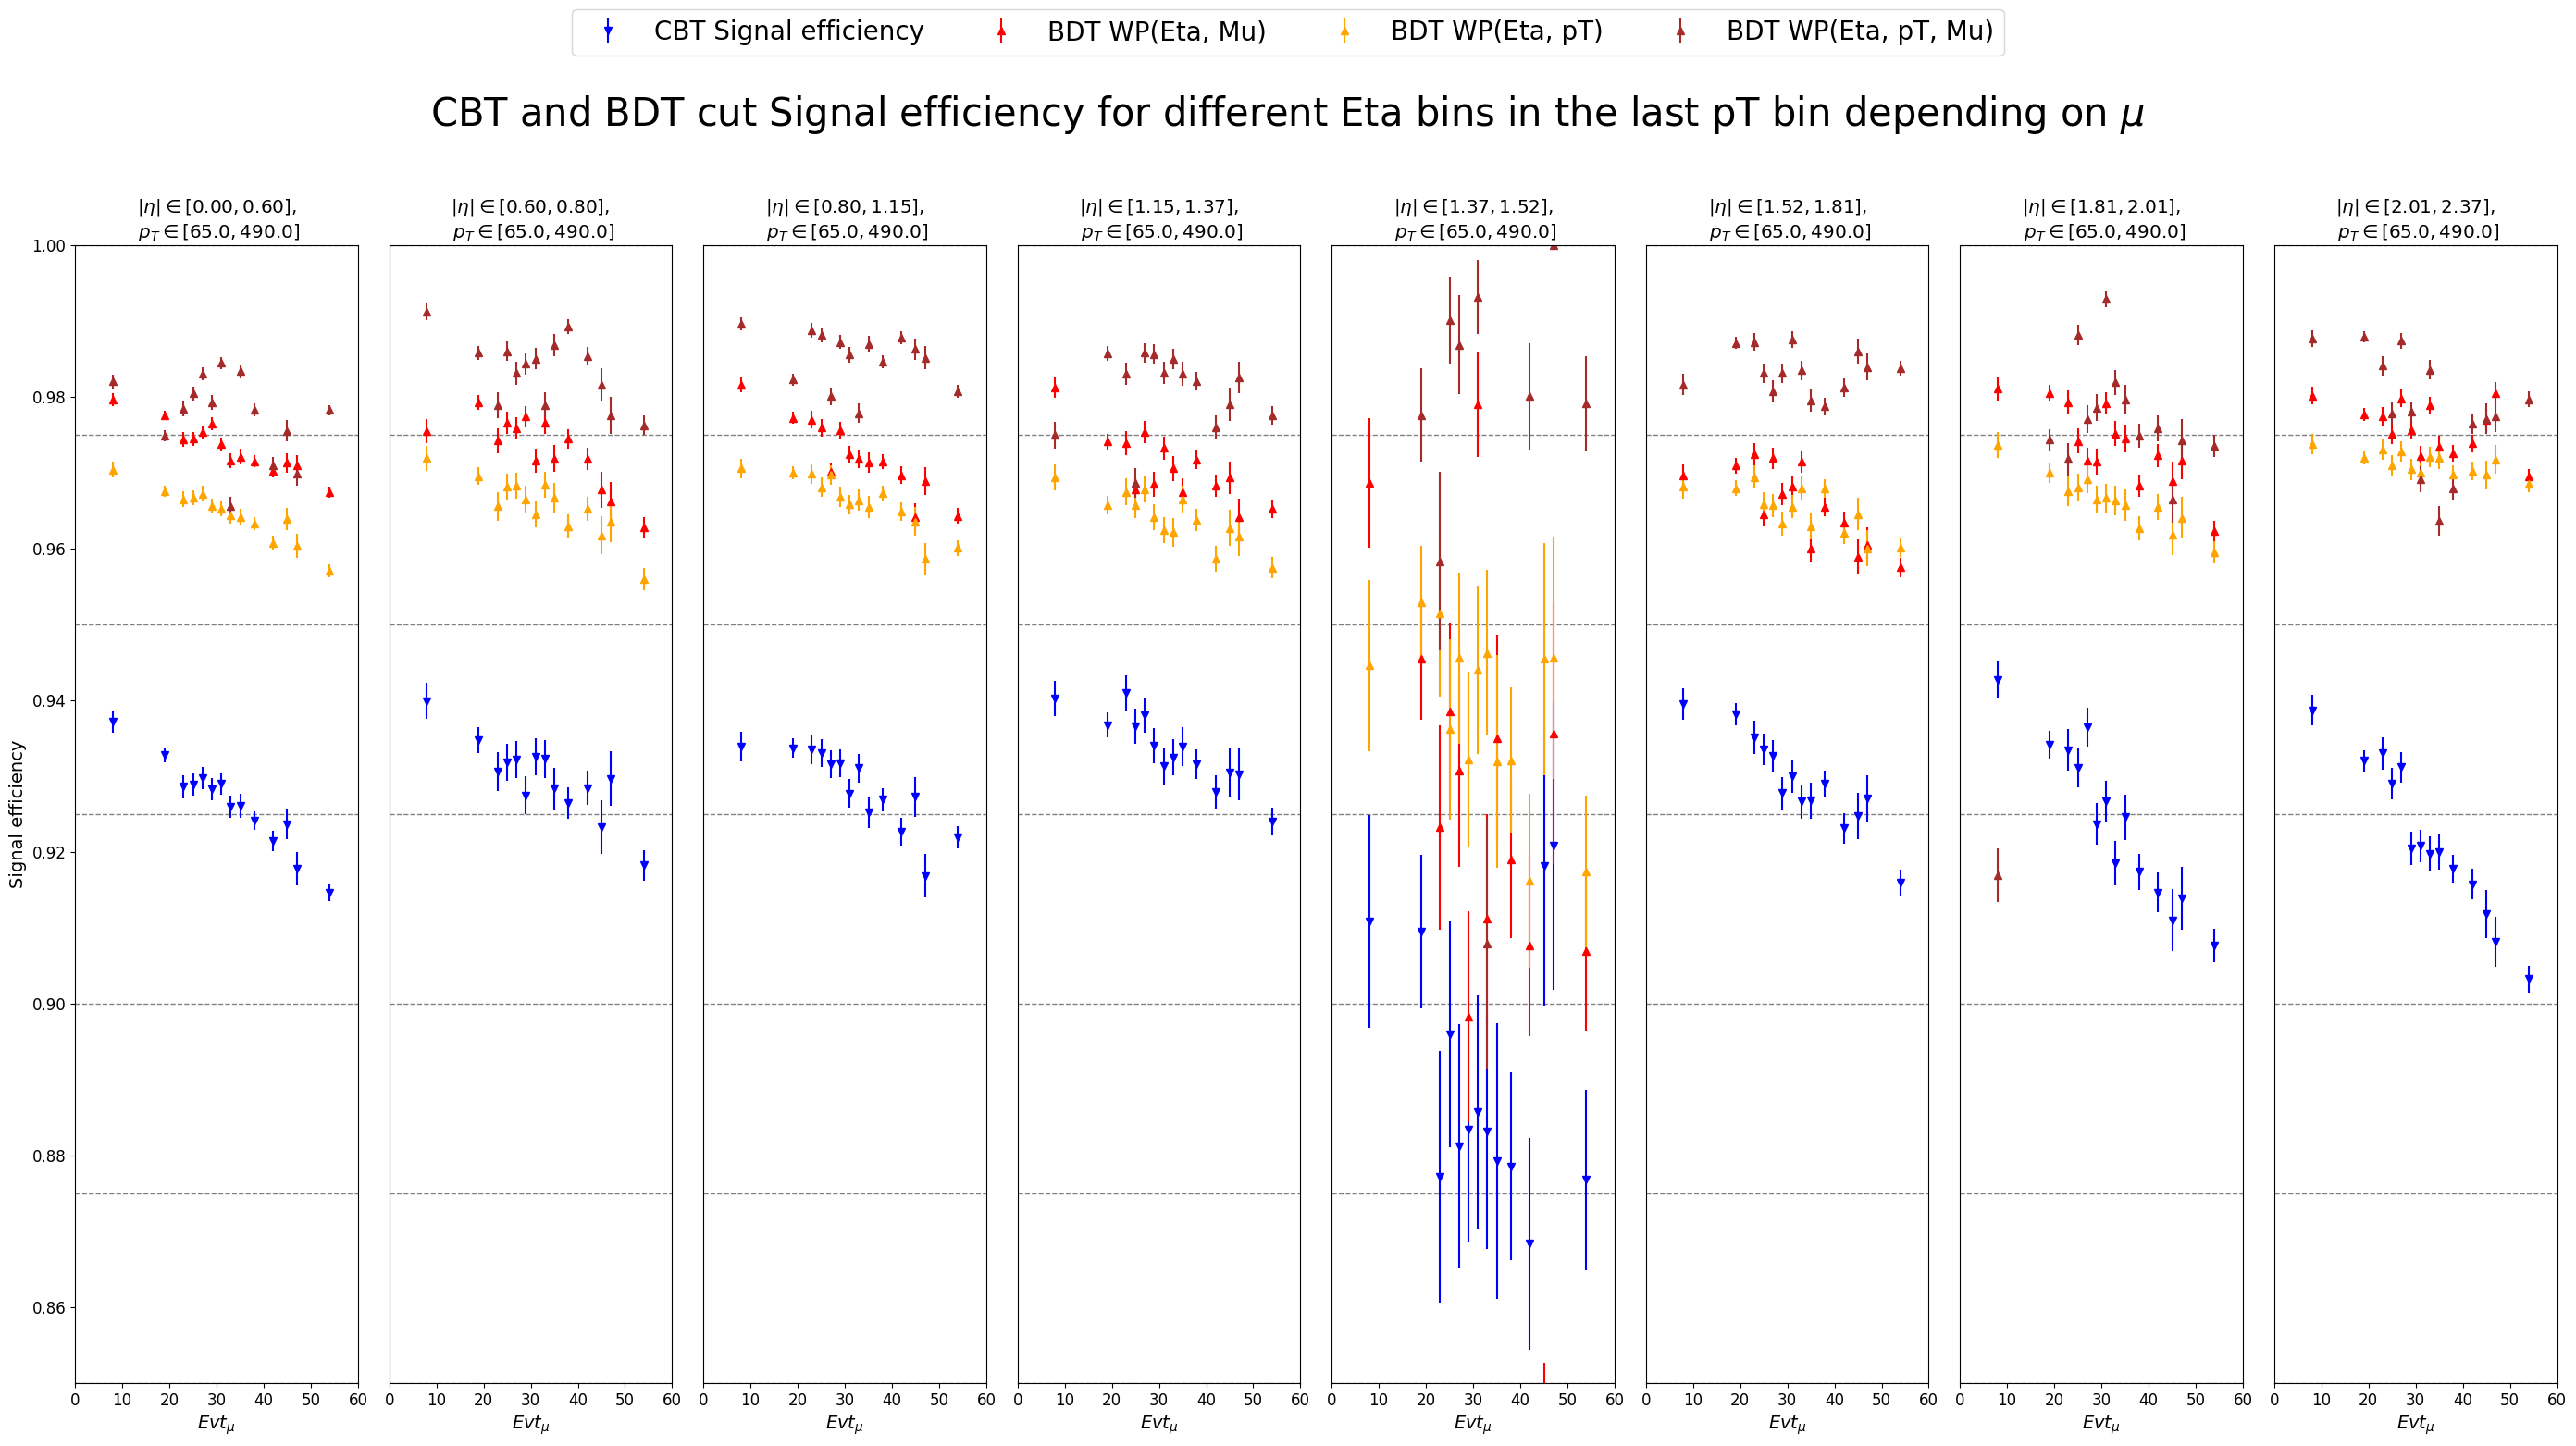

In [114]:
plt.rcParams.update({'font.size': 12})

num_eta_bins = len(edges_eta) - 1
last_pt_bin = num_pt_bins - 1

fig_last_pt_bin, axes_last_pt_bin = plt.subplots(nrows=1, ncols=num_eta_bins, figsize=(28, 15))
fig_last_pt_bin.subplots_adjust(wspace=0.3, hspace=0.4)

handles = []
labels = []

for i in range(num_eta_bins):
    ax = axes_last_pt_bin[i]
    
    ax.axhline(y=0.85, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=0.875, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=0.90, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=0.925, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=0.95, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=0.975, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=1.0, color='grey', linestyle='--', linewidth=1)

    errorbar_tight_sig = ax.errorbar(mu, eff_sig_tight_EtaMu[i], efferr_sig_tight_EtaMu[i],
                                     fmt="v", label='CBT Signal efficiency', color='blue')

    errorbar_bdt_wp_eta_mu = ax.errorbar(mu, eff_sig_bdt_EtaMu_WPEtaMu[i], efferr_sig_bdt_EtaMu_WPEtaMu[i],
                                         fmt="^", label='BDT WP(Eta, Mu)', color='red')
    
    errorbar_bdt_wp_eta_pt = ax.errorbar(mu, eff_sig_bdt_EtaMu_WPEtapT[i], efferr_sig_bdt_EtaMu_WPEtapT[i],
                                         fmt="^", label='BDT WP(Eta, pT)', color='orange')

    errorbar_bdt_wp_eta_pt_mu = ax.errorbar(mu, eff_sig_bdt_EtapTmu_WPEtapTmu[i, last_pt_bin, :], efferr_sig_bdt_EtapTmu_WPEtapTmu[i, last_pt_bin, :],
                                            fmt="^", label='BDT WP(Eta, pT, Mu)', color='brown') 

    if i == 0:
        handles.extend([errorbar_tight_sig, errorbar_bdt_wp_eta_mu, errorbar_bdt_wp_eta_pt, errorbar_bdt_wp_eta_pt_mu])
        labels.extend(['CBT Signal efficiency', 'BDT WP(Eta, Mu)', 'BDT WP(Eta, pT)', 'BDT WP(Eta, pT, Mu)'])

    ax.set_title(f"$|\eta| \in [{edges_eta[i]:.2f}, {edges_eta[i+1]:.2f}]$,\n $p_T \in [{edges_pt_sig[j]:.1f}, {edges_pt_sig[j+1]:.1f}]$")
    ax.set_ylim(0.85, 1.0)
    ax.set_xlim(0.0, 60)
    
    if i != 0:
        ax.set_yticks([])

    ax.set_xlabel("$Evt_{\mu}$", fontsize=14)

axes_last_pt_bin[0].set_ylabel("Signal efficiency", fontsize=14)

fig_last_pt_bin.suptitle('CBT and BDT cut Signal efficiency for different Eta bins in the last pT bin depending on $\mu$', fontsize=30)
fig_last_pt_bin.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.96])
#plt.savefig(savedir + "CBT and BDT cut Signal efficiency for different Eta bins in the last pT bin depending on Pileup.pdf")
plt.show()


# Signal integration over pT

In [118]:
# Signal Intégration sur l'axe 'pt'
den_sig_integrated_EtapTmu = den_sig_EtapTmu.project("eta", "evt_mu")
# Signal Intégration sur l'axe 'pt' pour les données tight
num_sig_tight_integrated_EtapTmu = num_sig_tight_EtapTmu.project("eta", "evt_mu")
# Signal Intégration sur l'axe 'pt' pour les données BDT
num_sig_bdt_integrated_EtapTmu_WPEtapTmu = num_sig_bdt_EtapTmu_WPEtapTmu.project("eta", "evt_mu")

In [119]:
eff_sig_bdt_integrated_EtapTmu_WPEtapTmu, efferr_sig_bdt_integrated_EtapTmu_WPEtapTmu = efficiency(num_sig_bdt_integrated_EtapTmu_WPEtapTmu, den_sig_integrated_EtapTmu)
eff_sig_tight_integrated_EtapTmu, efferr_sig_tight_integrated_EtapTmu = efficiency(num_sig_tight_integrated_EtapTmu, den_sig_integrated_EtapTmu)

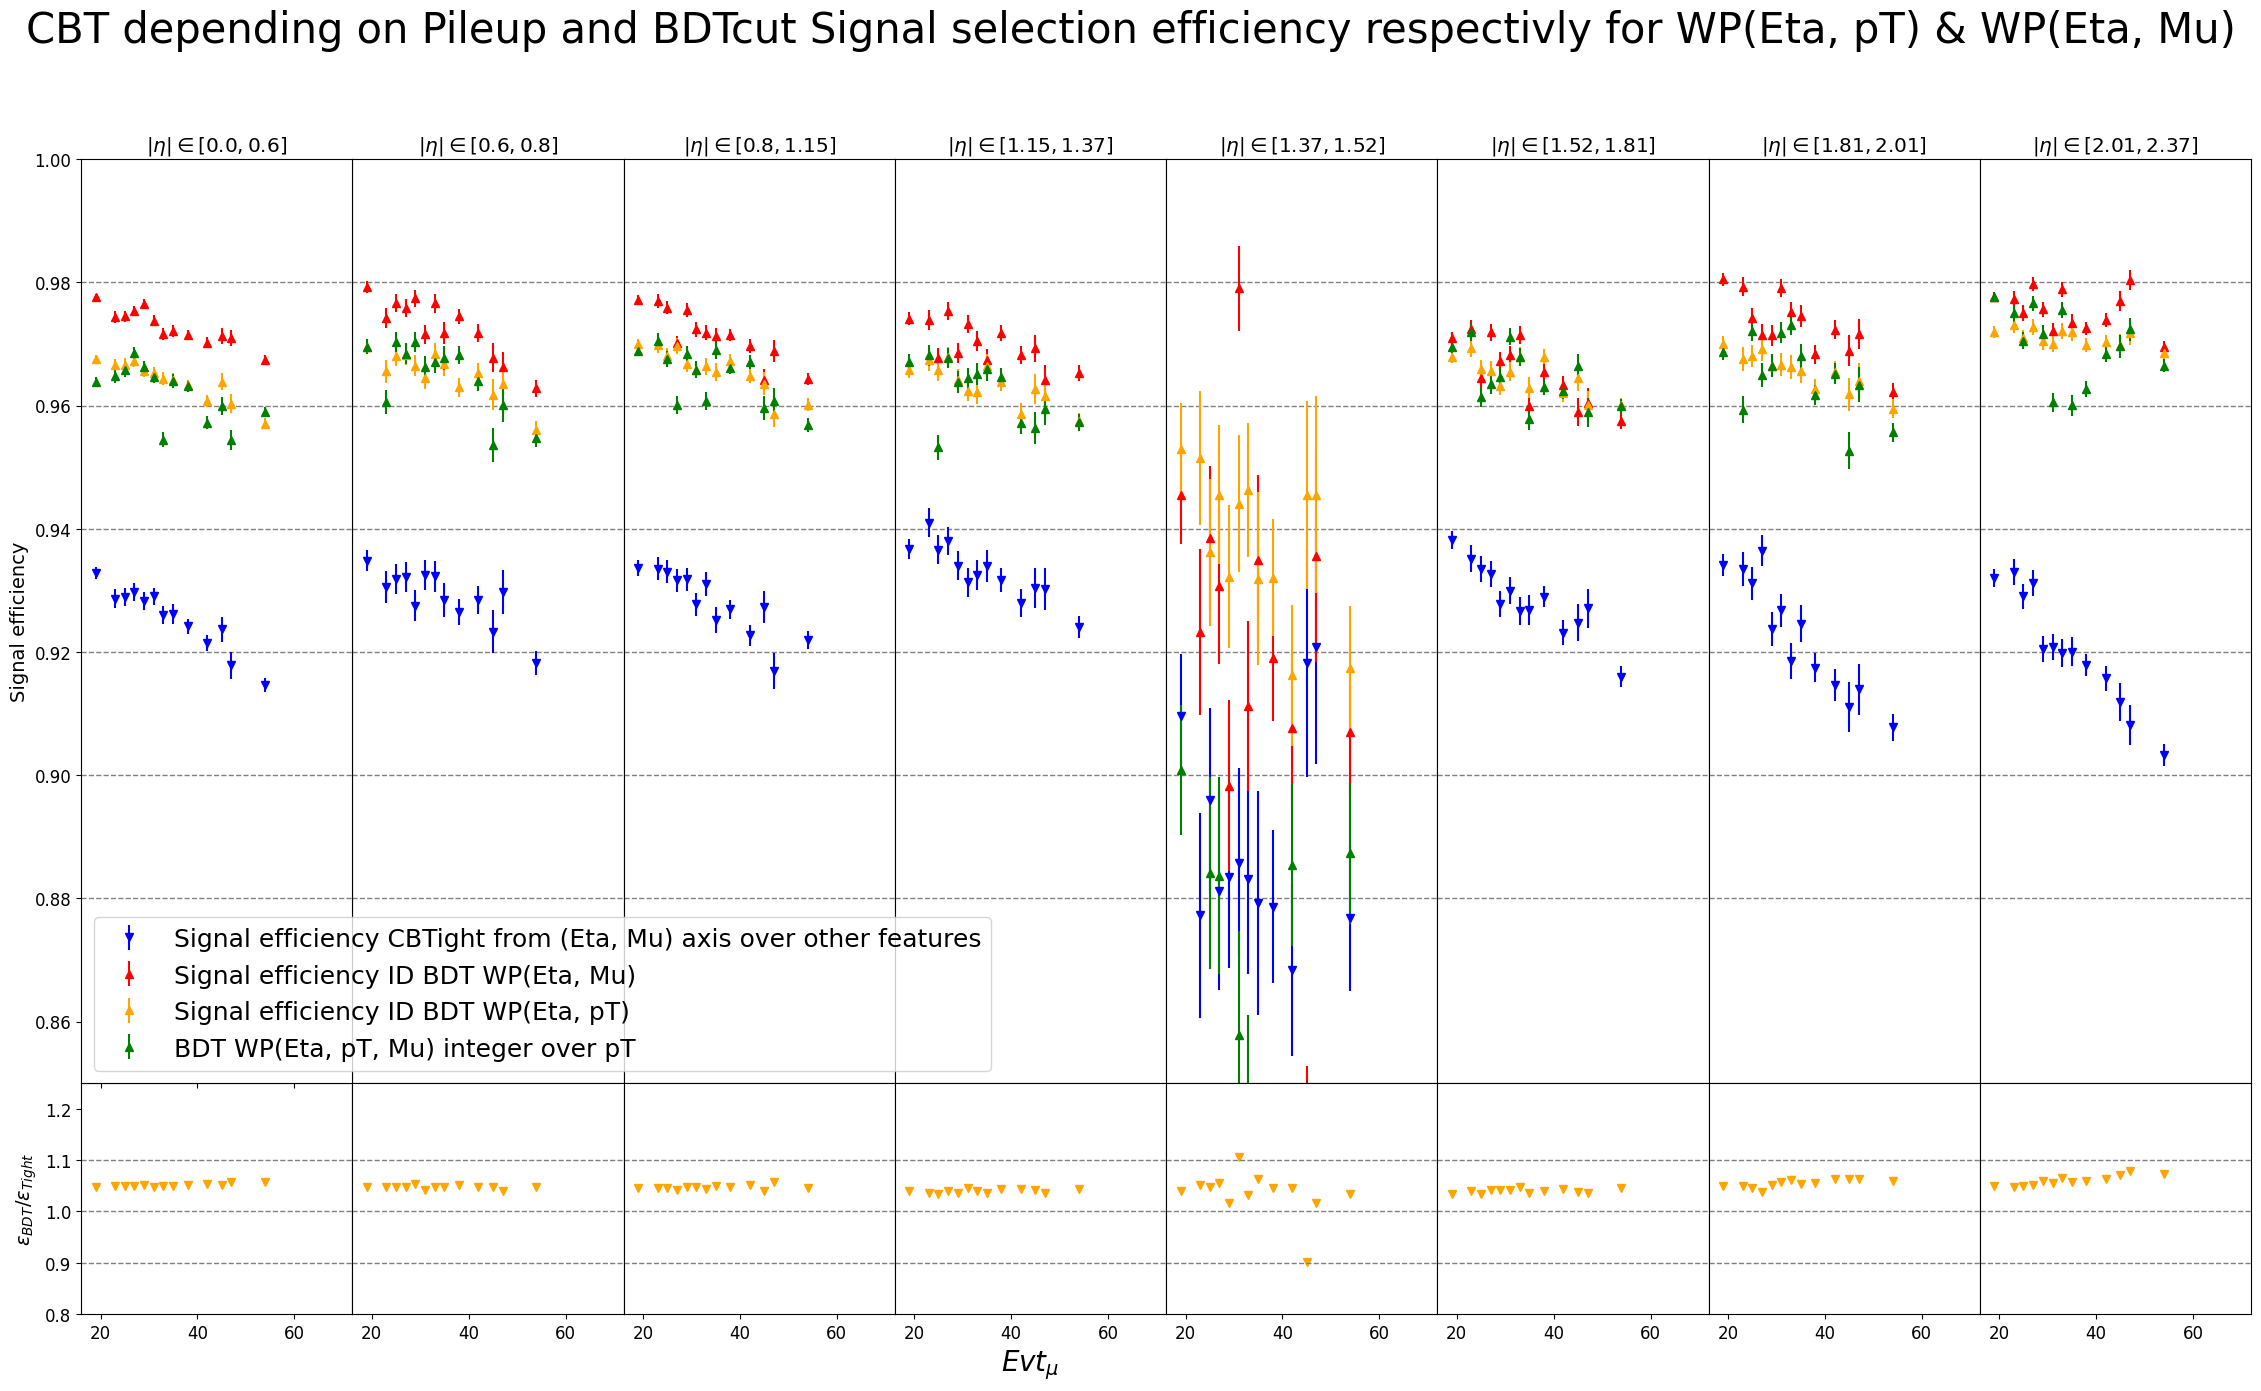

In [142]:
plt.rcParams.update({'font.size': 12})

fig, (ax, rax) = plt.subplots(nrows=2, ncols=8, figsize=(28,15), 
                              gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):

    ax[i].axhline(y=0.88, color='grey', linestyle='--', linewidth=1)
    ax[i].axhline(y=0.90, color='grey', linestyle='--', linewidth=1)
    ax[i].axhline(y=0.92, color='grey', linestyle='--', linewidth=1)
    ax[i].axhline(y=0.94, color='grey', linestyle='--', linewidth=1)
    ax[i].axhline(y=0.96, color='grey', linestyle='--', linewidth=1)
    ax[i].axhline(y=0.98, color='grey', linestyle='--', linewidth=1)
    
    ax[i].errorbar(mu, eff_sig_tight_EtaMu[i], efferr_sig_tight_EtaMu[i],
        fmt="v", label='Signal efficiency CBTight from (Eta, Mu) axis over other features', color = 'blue') 
    
    ax[i].errorbar(mu, eff_sig_bdt_EtaMu_WPEtaMu[i], efferr_sig_bdt_EtaMu_WPEtaMu[i],
        fmt="^", label='Signal efficiency ID BDT WP(Eta, Mu)', color = 'red') 
    
    ax[i].errorbar(mu, eff_sig_bdt_EtaMu_WPEtapT[i], efferr_sig_bdt_EtaMu_WPEtapT[i],
        fmt="^", label='Signal efficiency ID BDT WP(Eta, pT)', color = 'orange') 

    ax[i].errorbar(mu, eff_sig_bdt_integrated_EtapTmu_WPEtapTmu[i,:], efferr_sig_bdt_integrated_EtapTmu_WPEtapTmu[i,:],
                                         fmt="^", label='BDT WP(Eta, pT, Mu) integer over pT', color='green')

    
    
    #ax[i].set_xscale('log')
    if (i!=0):
        ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    rax[i].plot(mu, eff_sig_bdt_EtaMu_WPEtaMu[i]/eff_sig_tight_EtaMu[i], 'v', color = 'orange')
    rax[i].axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=0.9, color='grey', linestyle='--', linewidth=1)
    rax[i].set_xlim([16, 72])
    rax[i].set_ylim([0.8, 1.25])
    ax[i].set_ylim([0.85, 1.0])
    if (i!=0):
        rax[i].set_yticks([])
        
rax[0].set_ylabel(r'$\epsilon_{BDT}$/$\epsilon_{Tight}$', fontsize=14)
ax[0].set_ylabel("Signal efficiency",  fontsize=14)
rax[3].set_xlabel("$Evt_{\mu}$",  fontsize=20)
ax[0].set_zorder(ax[1].get_zorder() + 1)
ax[0].legend(fontsize = 18)

fig.suptitle('CBT depending on Pileup and BDTcut Signal selection efficiency respectivly for WP(Eta, pT) & WP(Eta, Mu)', fontsize=30)

#plt.savefig(savedir+"CBT depending on Pileup and BDTcut Signal selection efficiency respectivly for WP(Eta, pT) & WP(Eta, Mu).pdf")
plt.show()